In [1]:
# Run this cell to mount your Google Drive.

from IPython.display import clear_output, Image
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


# Imports

In [2]:
# !pip install rlcard
!pip install rlcard[torch]
!pip install rlcard[tensorflow]

clear_output()

In [3]:
import torch
import numpy as np
import tensorflow
import os
import importlib

# path
pth = '/content/drive/MyDrive/Colab Notebooks/Thesis'

%cd /content/drive/My Drive/Colab Notebooks/Thesis/SupervisedLearning

from MLP import *
from models import *

# remove pycache
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/agents/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/envs/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/games/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/utils/
%rm -r __pycache__
%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn/rlcard/
%rm -r __pycache__

%cd /content/drive/My Drive/Colab Notebooks/Thesis/dqn

try:
    importlib.reload(rlcard)
    importlib.reload(rlcard.utils)
    importlib.reload(rlcard.agents.random_agent)
    importlib.reload(rlcard.agents.dqn_agent_pytorch)
    importlib.reload(rlcard.agents.simpleGinRummy_agent)
    importlib.reload(rlcard.games.gin_rummy.utils.scorers)
except:
    pass

import rlcard
from rlcard.utils import set_global_seed, tournament, tournament2, tournament3
from rlcard.utils import Logger
from rlcard.agents.random_agent import RandomAgent
from rlcard.agents.dqn_agent_pytorch import DQNAgent
from rlcard.agents.simpleGinRummy_agent import SimpleGinRummyAgent

# different versions of payoff functions
from rlcard.games.gin_rummy.utils.scorers import *

%cd /content/drive/My Drive/Colab Notebooks/Thesis

clear_output()

In [4]:
agent = 0
def load_checkpoint(checkpoint, agent=agent):
    # load DQN pretrained weights using built in load function
    if isDQN:
        agent.load(checkpoint)
        agent2.load(checkpoint)
    else:
        model_dict = checkpoint.state_dict()
        # Generate pretrained dictionary of weights/biases
        pretrained_dict = {}

        # check if there is batch norm layer
        if batch_norm:
            b_layer = 1 
            pretrained_dict['fc_layers.1.weight'] = agent.q_estimator.qnet.fc_layers[1].weight
            pretrained_dict['fc_layers.1.bias'] = agent.q_estimator.qnet.fc_layers[1].bias
            pretrained_dict['fc_layers.1.running_mean'] = agent.q_estimator.qnet.fc_layers[1].running_mean
            pretrained_dict['fc_layers.1.running_var'] = agent.q_estimator.qnet.fc_layers[1].running_var
            pretrained_dict['fc_layers.1.num_batches_tracked'] = agent.q_estimator.qnet.fc_layers[1].num_batches_tracked
        else:
            b_layer = 0
        curr_layer = b_layer + 1
        for i in range(len(mlp_layers)):
            pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['l{}.weight'.format(i+1)]
            pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['l{}.bias'.format(i+1)]
            curr_layer += 2
        # check if there is a top_layer
        if top_layer:
            # check if copy top layer weights
            if copy_top:
                pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = torch.tensor(np.eye(110), device=device)
                pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = torch.tensor(np.zeros(110), device=device)
            else:
                pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = agent.target_estimator.qnet.fc_layers[curr_layer].weight
                pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = agent.target_estimator.qnet.fc_layers[curr_layer].bias
            curr_layer += 2

        # check if extra layer for knocking
        if knock_layer:
            pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = torch.tensor(np.eye(110), device=device)
            knock_probs = np.ones(110)*knock_val
            knock_probs[0:58] = 0
            pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = torch.tensor(knock_probs, device=device)
        
        # load pretrained weights
        agent.q_estimator.qnet.load_state_dict(pretrained_dict)
        agent.target_estimator.qnet.load_state_dict(pretrained_dict)
    
    # check if freeze layers (DO NOT FREEZE TOP LAYER)
    curr_layer = 1
    if freeze_layers:
        if batch_norm:
            agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
            agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
            agent.target_estimator.qnet.fc_layers[1].weight.requires_grad = False
            agent.target_estimator.qnet.fc_layers[1].bias.requires_grad = False
        curr_layer += b_layer
        for i in range(len(mlp_layers)):
            agent.q_estimator.qnet.fc_layers[curr_layer].weight.requires_grad = False
            agent.q_estimator.qnet.fc_layers[curr_layer].bias.requires_grad = False
            agent.target_estimator.qnet.fc_layers[curr_layer].weight.requires_grad = False
            agent.target_estimator.qnet.fc_layers[curr_layer].bias.requires_grad = False
            curr_layer += 2
        if top_layer:
            # there is additional top layer, do not freeze 
            pass
        else:
            # no additional top layer, unfreeze top layer 
            curr_layer -= 2
        # unfreeze top layers
        agent.q_estimator.qnet.fc_layers[curr_layer].weight.requires_grad = True
        agent.q_estimator.qnet.fc_layers[curr_layer].bias.requires_grad = True
        agent.target_estimator.qnet.fc_layers[curr_layer].weight.requires_grad = True
        agent.target_estimator.qnet.fc_layers[curr_layer].bias.requires_grad = True
        curr_layer += 2
        # check if extra layer for knocking
        if knock_layer:
            agent.q_estimator.qnet.fc_layers[curr_layer].weight.requires_grad = False
            agent.q_estimator.qnet.fc_layers[curr_layer].bias.requires_grad = False
            agent.target_estimator.qnet.fc_layers[curr_layer].weight.requires_grad = False
            agent.target_estimator.qnet.fc_layers[curr_layer].bias.requires_grad = False

# Identity Testing

In [5]:
dir = 'identity'    # root directory name for group of models

## test1

Test identity and bias trained

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 40000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = False
knock_layer = True
knock_val = 0.02
# knock_val = 0.01
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_and_bias.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
pretrained_dict['fc_layers.7.bias'] = model_dict_identity['l1.bias']

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

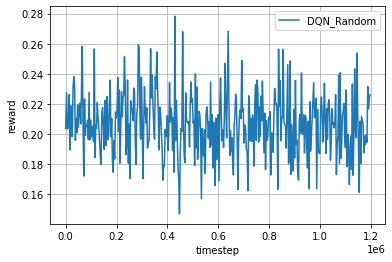

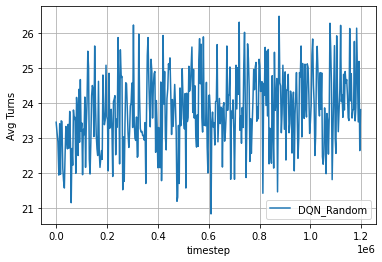

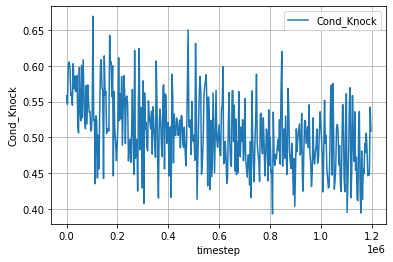

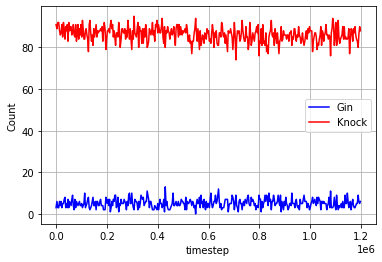

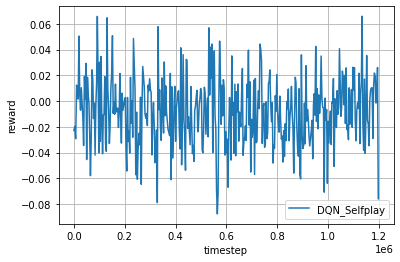

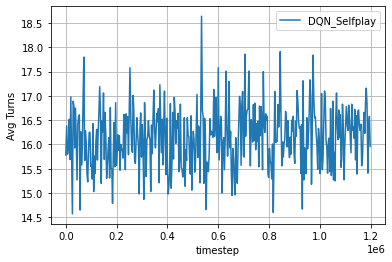

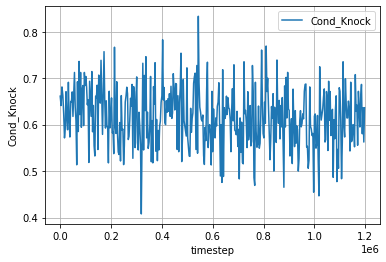

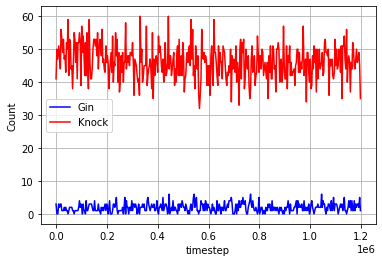

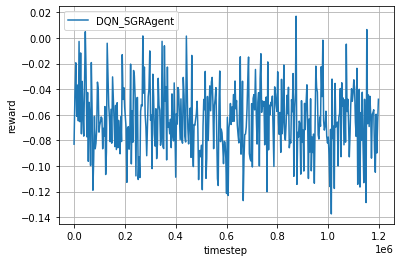

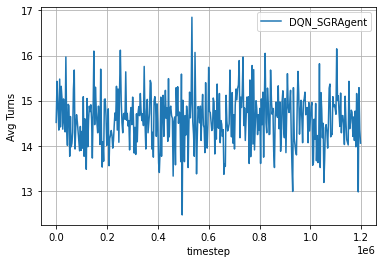

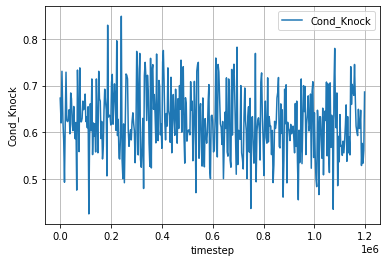

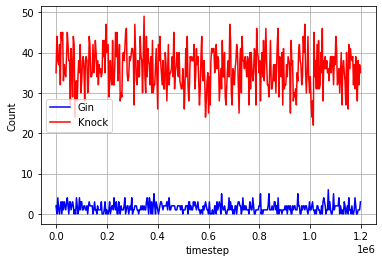

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 4, 'Knock': 87, 'Other': 9, 'Knock_Possible': 153, 'Avg Turns': 21.73}


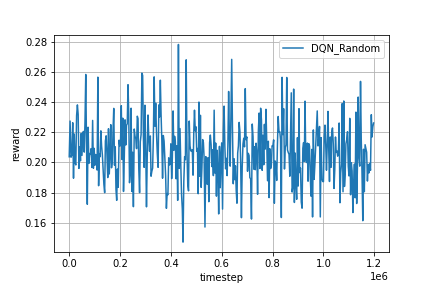

In [ ]:
Image(log_dir + '/rand_fig.png')

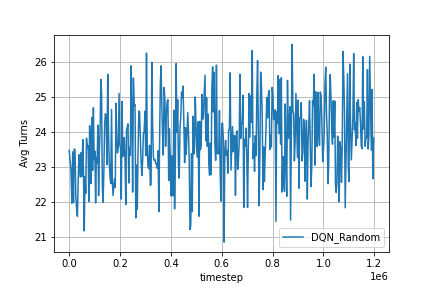

In [ ]:
Image(log_dir + '/rand_fig2.png')

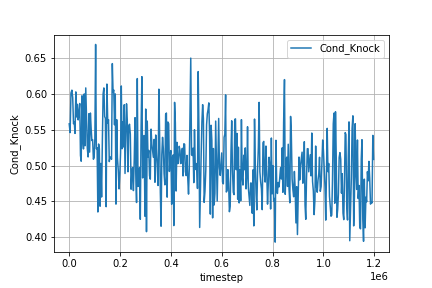

In [ ]:
Image(log_dir + '/rand_fig3.png')

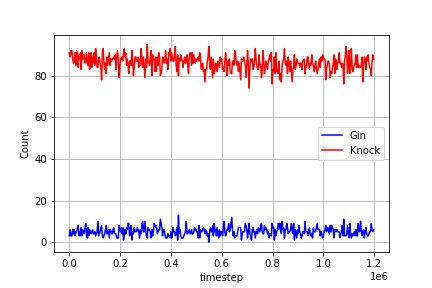

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 2, 'Knock': 37, 'Other': 61, 'Knock_Possible': 64, 'Avg Turns': 16.51}


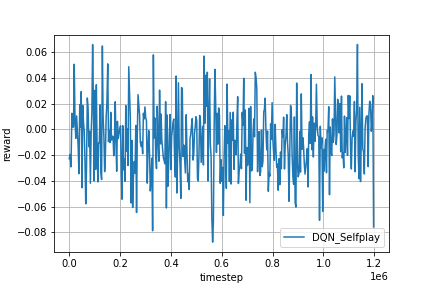

In [ ]:
Image(log_dir + '/self_fig.png')

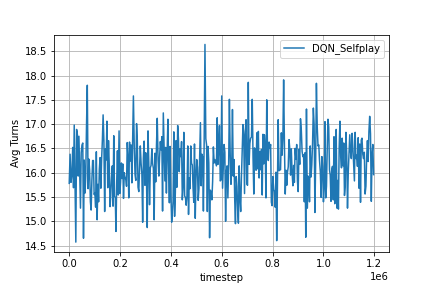

In [ ]:
Image(log_dir + '/self_fig2.png')

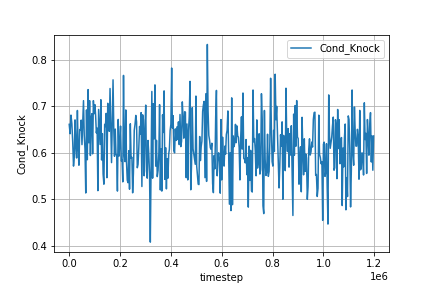

In [ ]:
Image(log_dir + '/self_fig3.png')

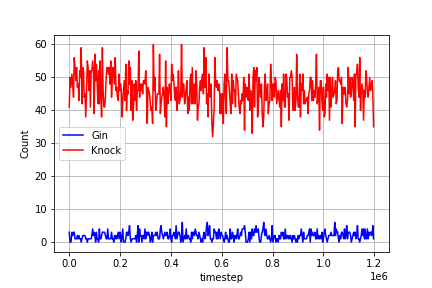

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 2, 'Knock': 33, 'Other': 65, 'Knock_Possible': 50, 'Avg Turns': 14.65}


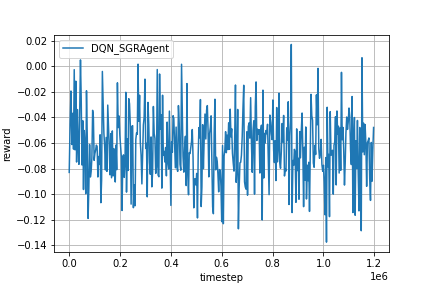

In [ ]:
Image(log_dir + '/sgr_fig.png')

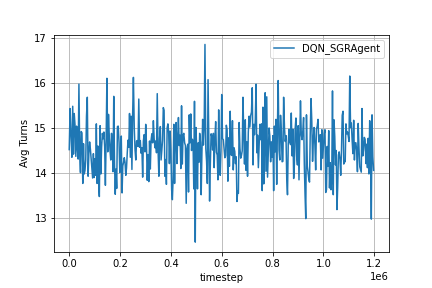

In [ ]:
Image(log_dir + '/sgr_fig2.png')

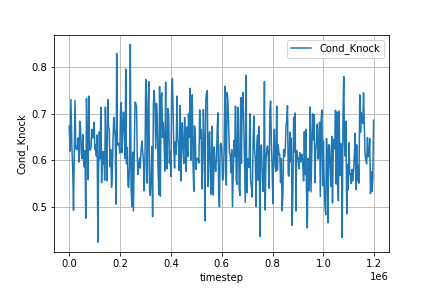

In [ ]:
Image(log_dir + '/sgr_fig3.png')

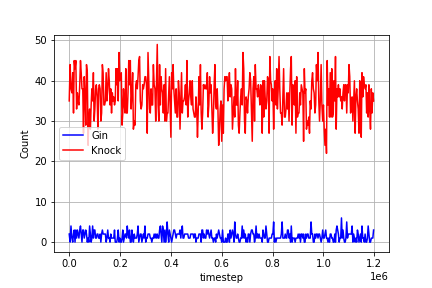

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test2

Test identity without and knock bias

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test2'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 40000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

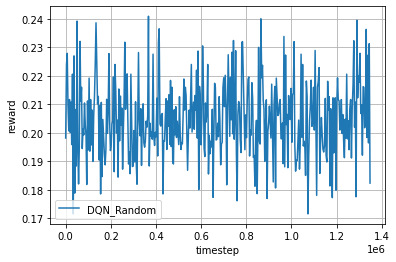

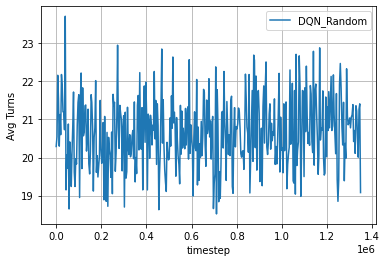

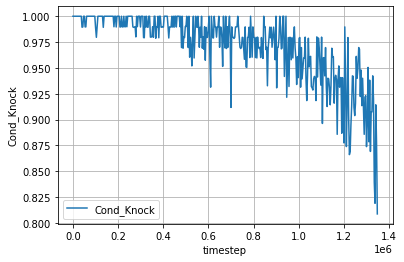

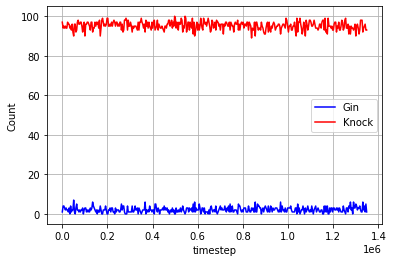

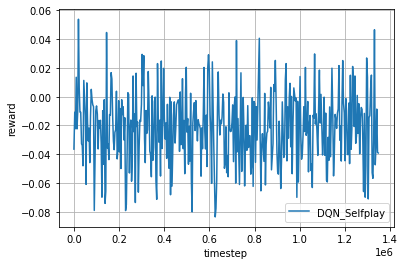

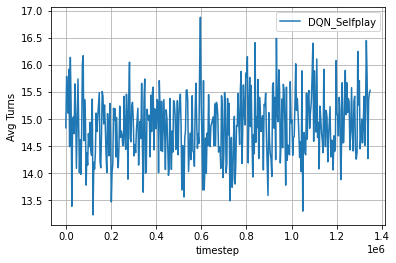

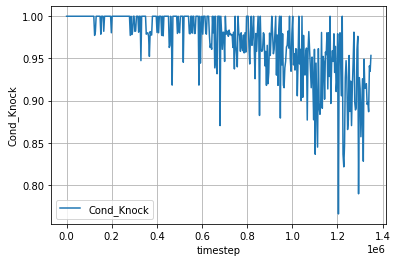

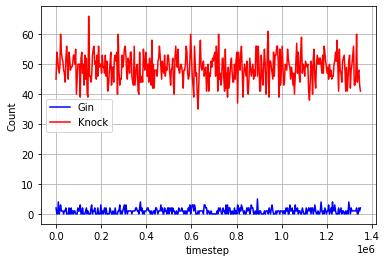

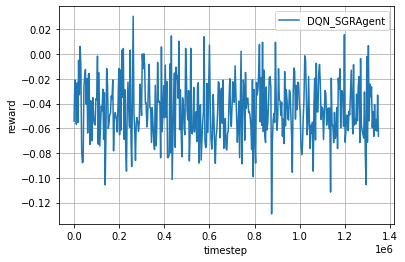

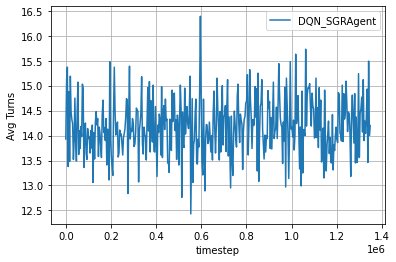

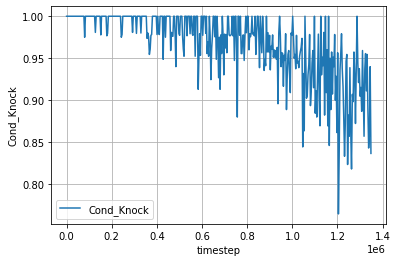

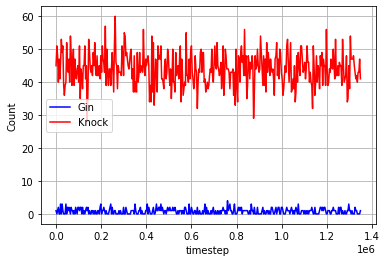

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 98, 'Other': 1, 'Knock_Possible': 104, 'Avg Turns': 20.56}


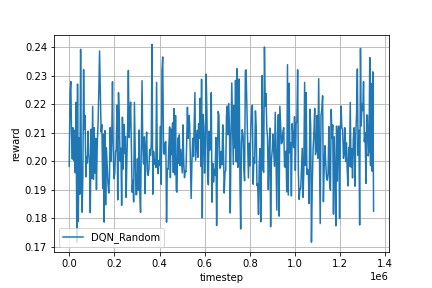

In [ ]:
Image(log_dir + '/rand_fig.png')

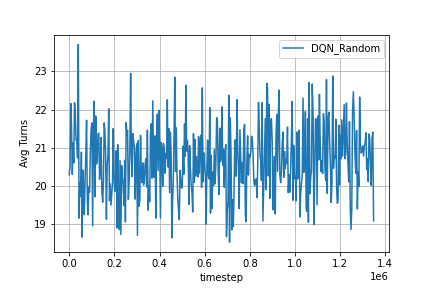

In [ ]:
Image(log_dir + '/rand_fig2.png')

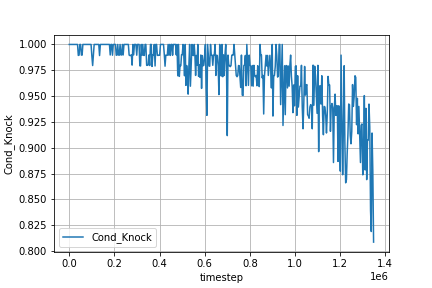

In [ ]:
Image(log_dir + '/rand_fig3.png')

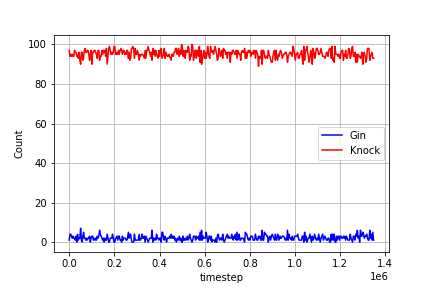

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 2, 'Knock': 43, 'Other': 55, 'Knock_Possible': 49, 'Avg Turns': 15.08}


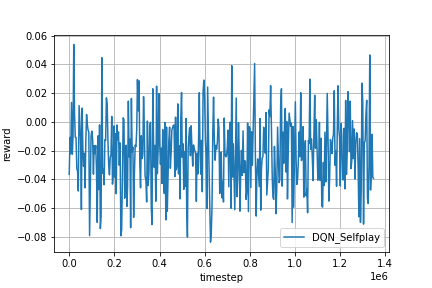

In [ ]:
Image(log_dir + '/self_fig.png')

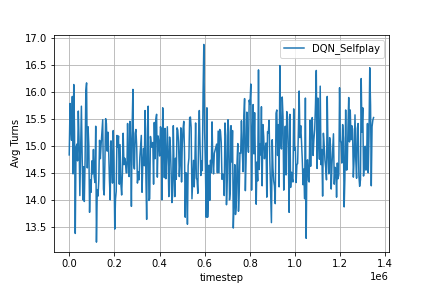

In [ ]:
Image(log_dir + '/self_fig2.png')

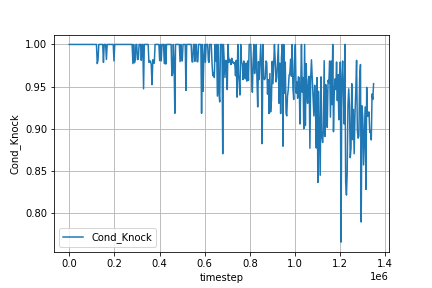

In [ ]:
Image(log_dir + '/self_fig3.png')

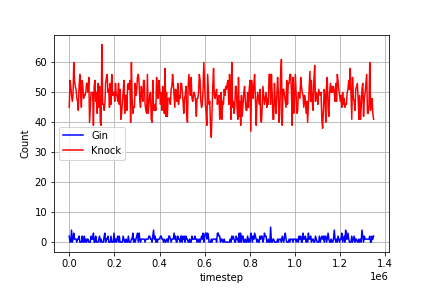

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 2, 'Knock': 37, 'Other': 61, 'Knock_Possible': 40, 'Avg Turns': 14.25}


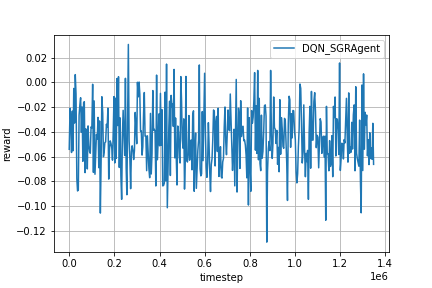

In [ ]:
Image(log_dir + '/sgr_fig.png')

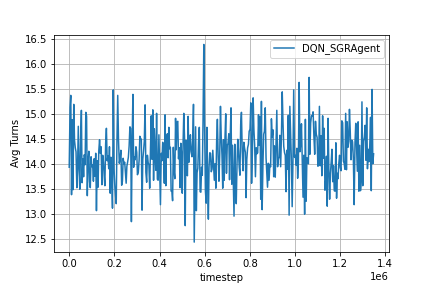

In [ ]:
Image(log_dir + '/sgr_fig2.png')

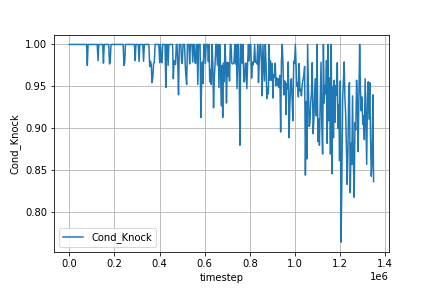

In [ ]:
Image(log_dir + '/sgr_fig3.png')

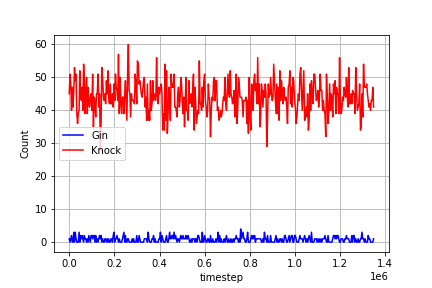

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test3

Test identity and bias trained, clamped

- all the data

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test3'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 40000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = False
knock_layer = True
knock_val = 0.02
# knock_val = 0.01
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_and_bias_clamp.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
pretrained_dict['fc_layers.7.bias'] = model_dict_identity['l1.bias']

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 6, 'Knock': 77, 'Other': 17, 'Knock_Possible': 183, 'Avg Turns': 26.6}


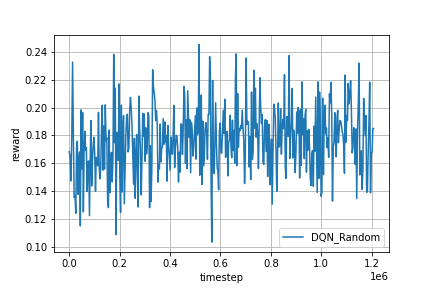

In [ ]:
Image(log_dir + '/rand_fig.png')

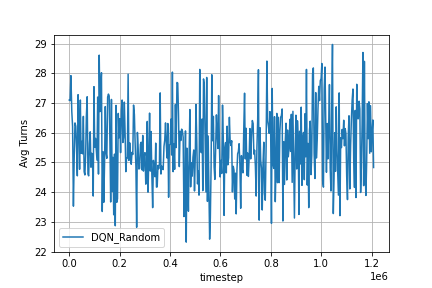

In [ ]:
Image(log_dir + '/rand_fig2.png')

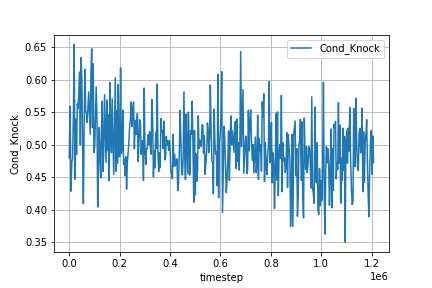

In [ ]:
Image(log_dir + '/rand_fig3.png')

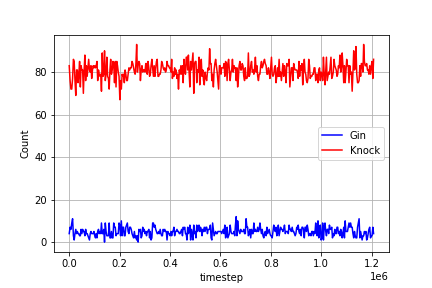

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 42, 'Other': 57, 'Knock_Possible': 79, 'Avg Turns': 16.98}


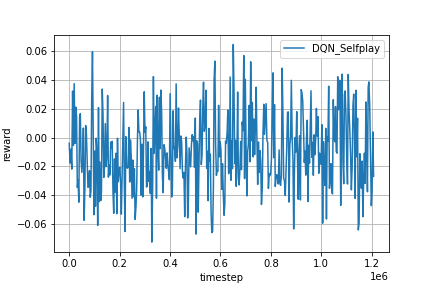

In [ ]:
Image(log_dir + '/self_fig.png')

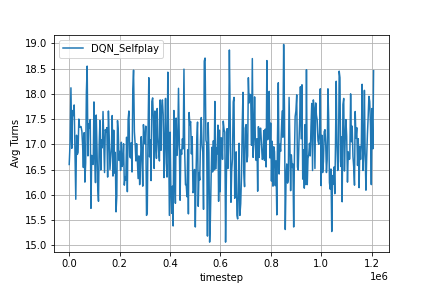

In [ ]:
Image(log_dir + '/self_fig2.png')

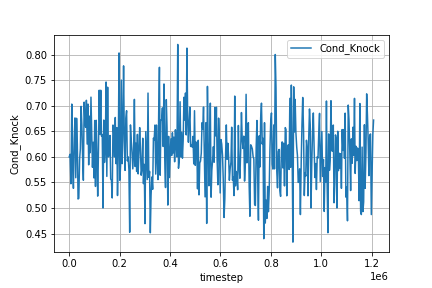

In [ ]:
Image(log_dir + '/self_fig3.png')

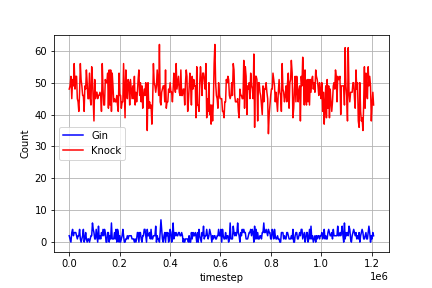

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 39, 'Other': 60, 'Knock_Possible': 60, 'Avg Turns': 15.41}


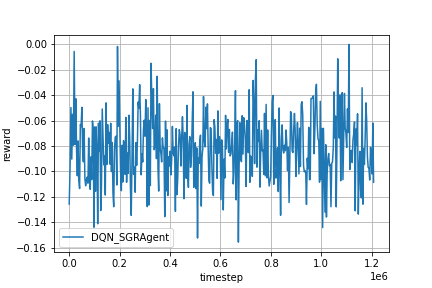

In [ ]:
Image(log_dir + '/sgr_fig.png')

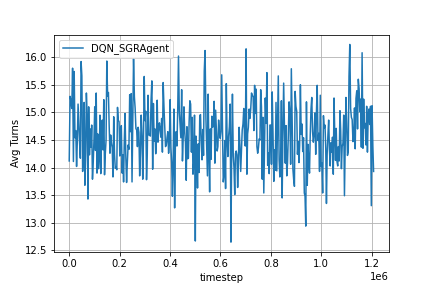

In [ ]:
Image(log_dir + '/sgr_fig2.png')

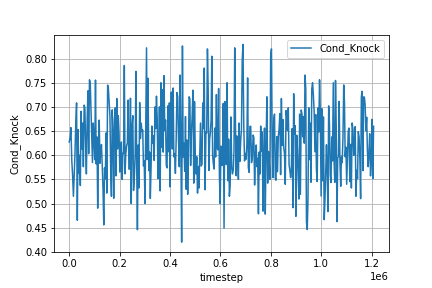

In [ ]:
Image(log_dir + '/sgr_fig3.png')

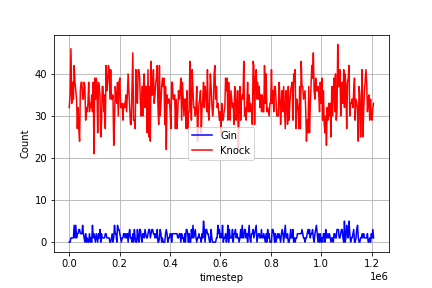

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test4

Test identity without and knock bias, clamped

- 10% of the total data

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test4'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 40000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias_clamp_point1.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

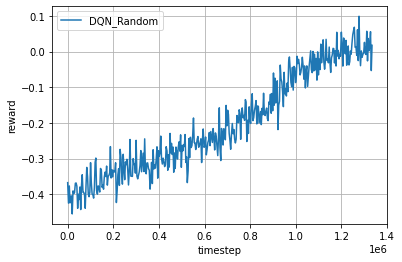

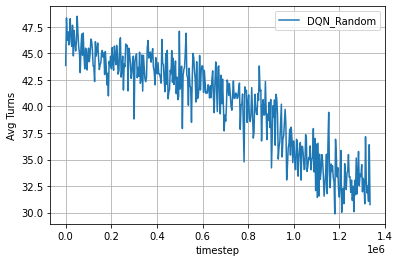

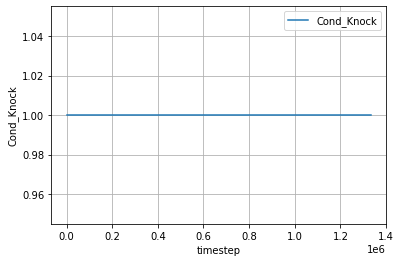

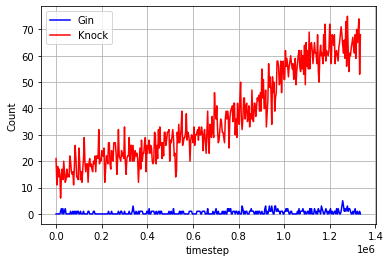

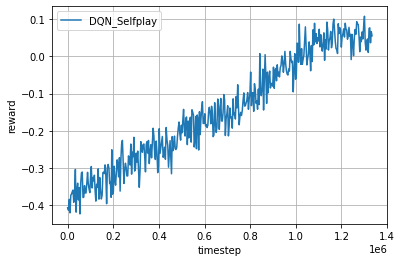

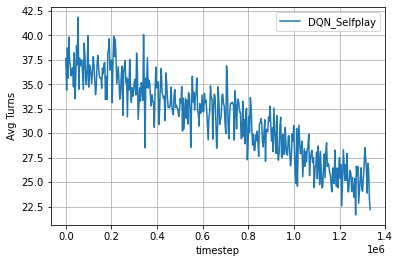

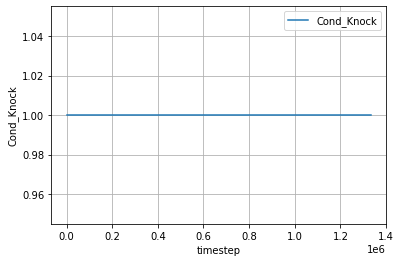

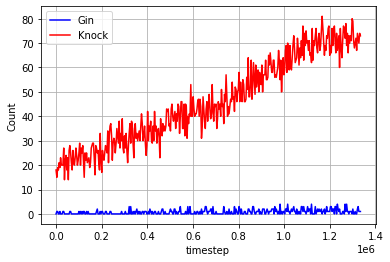

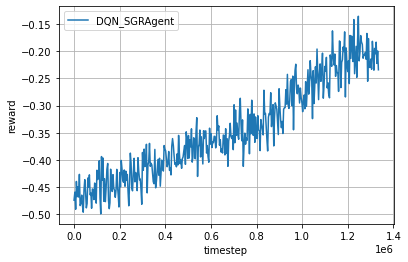

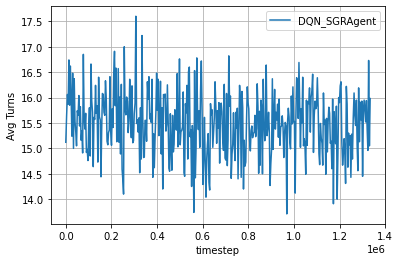

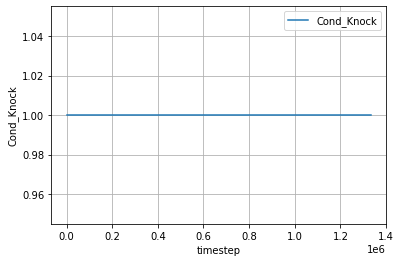

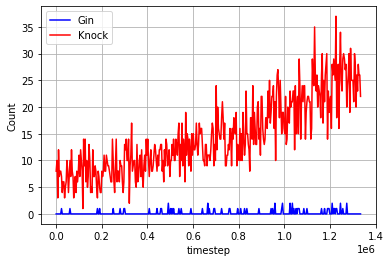

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 62, 'Other': 37, 'Knock_Possible': 62, 'Avg Turns': 33.1}


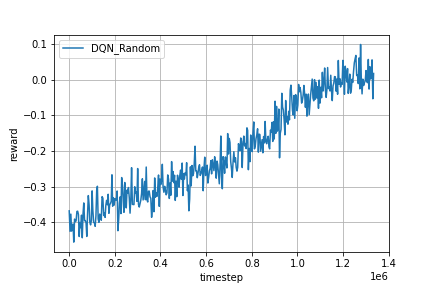

In [ ]:
Image(log_dir + '/rand_fig.png')

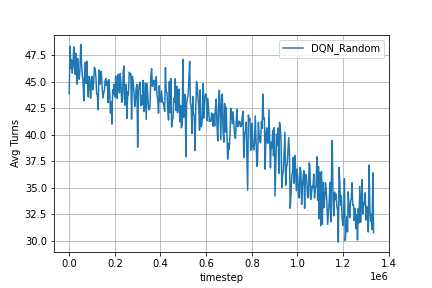

In [ ]:
Image(log_dir + '/rand_fig2.png')

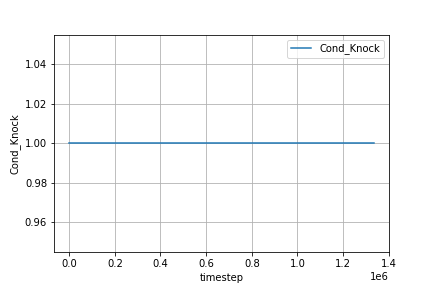

In [ ]:
Image(log_dir + '/rand_fig3.png')

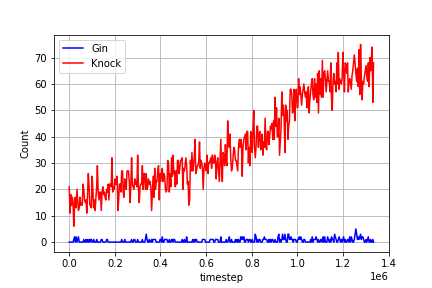

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 71, 'Other': 29, 'Knock_Possible': 71, 'Avg Turns': 25.03}


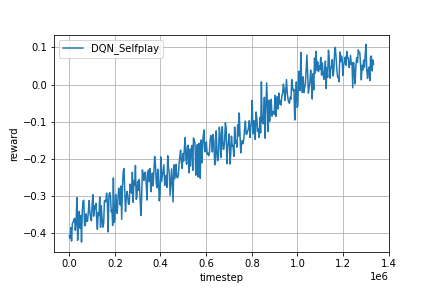

In [ ]:
Image(log_dir + '/self_fig.png')

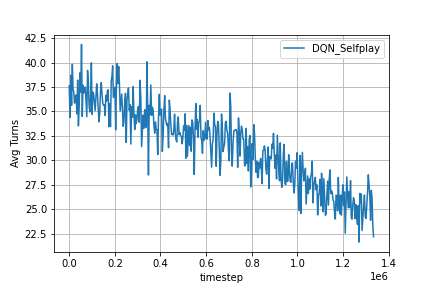

In [ ]:
Image(log_dir + '/self_fig2.png')

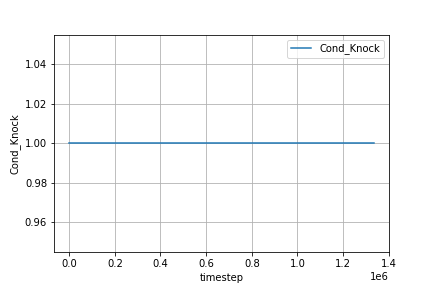

In [ ]:
Image(log_dir + '/self_fig3.png')

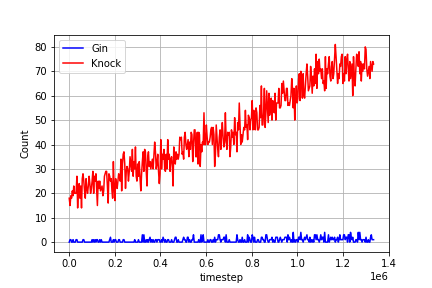

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 20, 'Other': 79, 'Knock_Possible': 20, 'Avg Turns': 14.94}


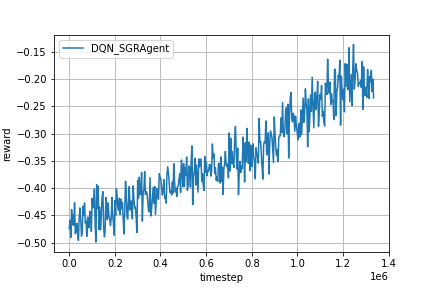

In [ ]:
Image(log_dir + '/sgr_fig.png')

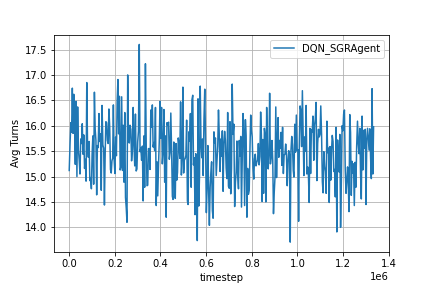

In [ ]:
Image(log_dir + '/sgr_fig2.png')

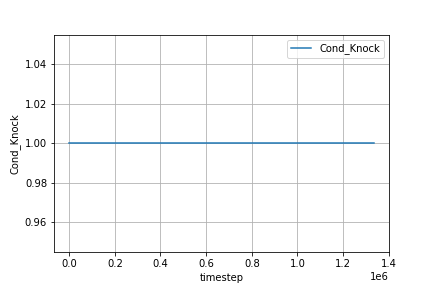

In [ ]:
Image(log_dir + '/sgr_fig3.png')

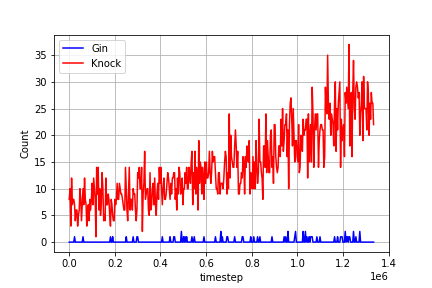

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test5

Test identity and bias trained, clamped

- 5K samples of the total data

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test5'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
# episode_num = 40000  # mahjong_dqn has 100000
episode_num = 2000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = False
knock_layer = True
knock_val = 0.02
# knock_val = 0.01
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_and_bias_clamp_5k.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
pretrained_dict['fc_layers.7.bias'] = model_dict_identity['l1.bias']

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

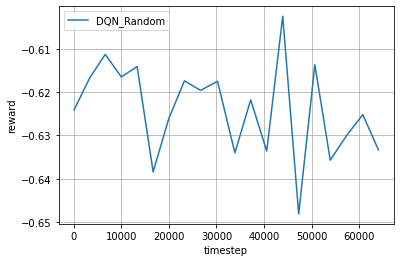

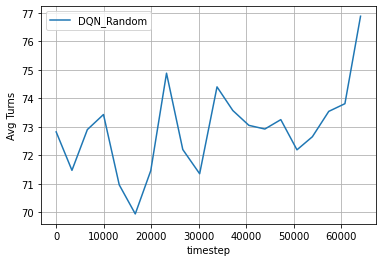

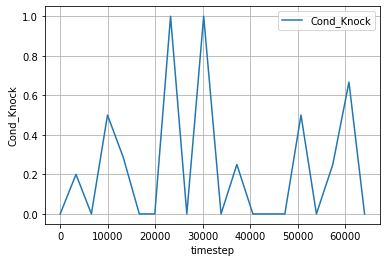

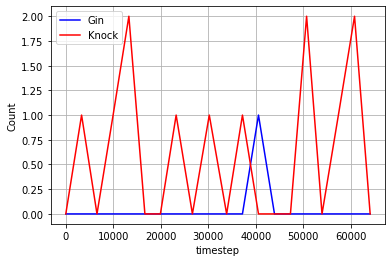

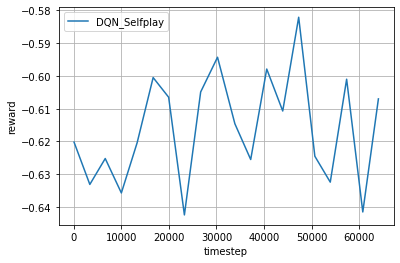

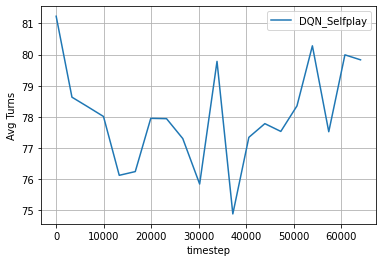

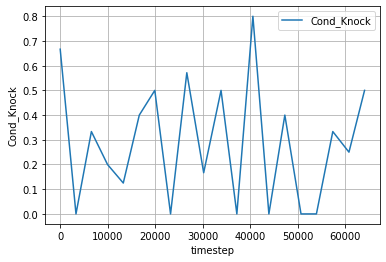

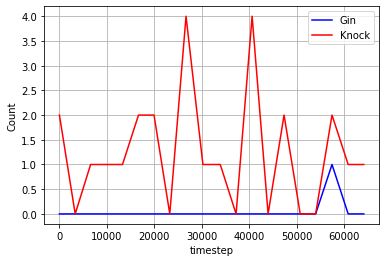

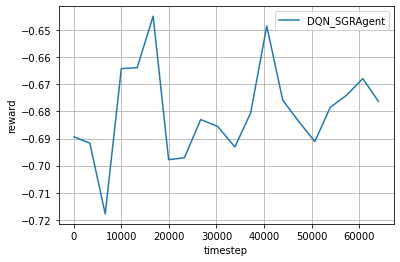

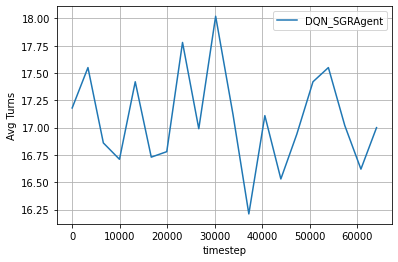

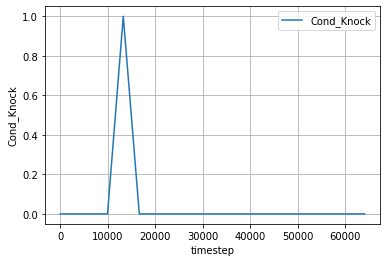

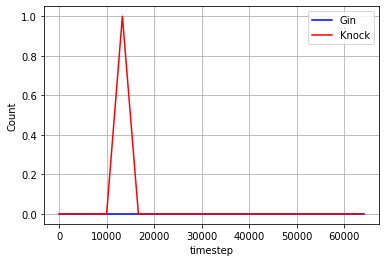

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 2, 'Other': 98, 'Knock_Possible': 3, 'Avg Turns': 73.34}


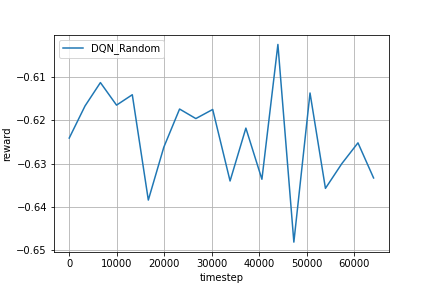

In [ ]:
Image(log_dir + '/rand_fig.png')

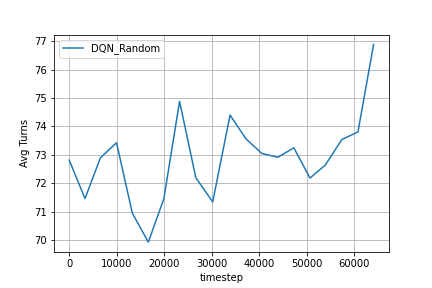

In [ ]:
Image(log_dir + '/rand_fig2.png')

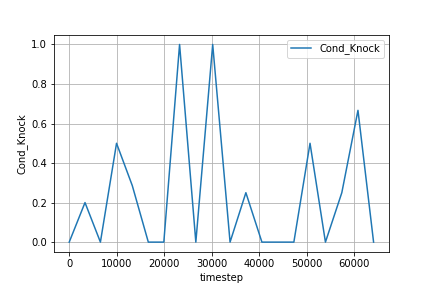

In [ ]:
Image(log_dir + '/rand_fig3.png')

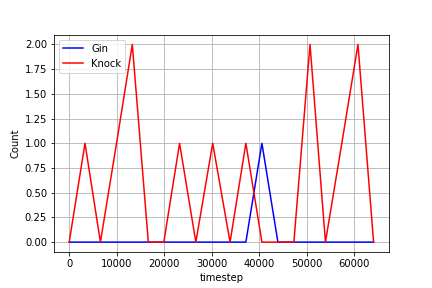

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 1, 'Other': 99, 'Knock_Possible': 3, 'Avg Turns': 78.43}


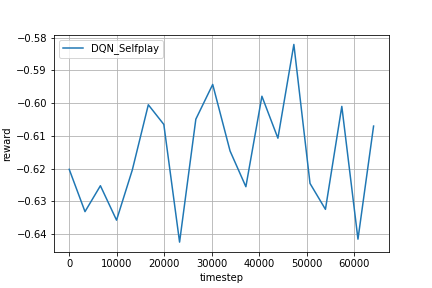

In [ ]:
Image(log_dir + '/self_fig.png')

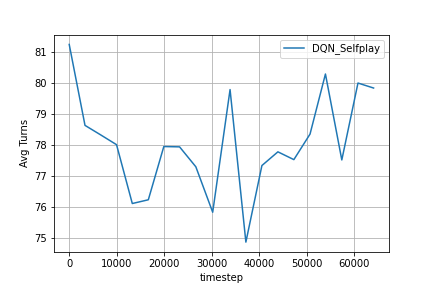

In [ ]:
Image(log_dir + '/self_fig2.png')

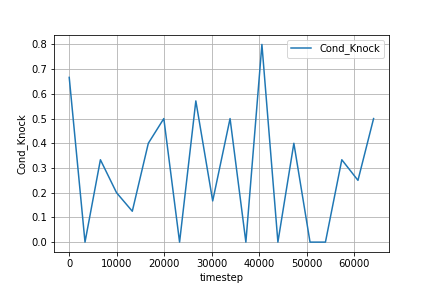

In [ ]:
Image(log_dir + '/self_fig3.png')

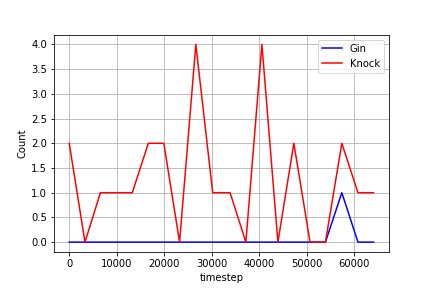

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 0, 'Other': 100, 'Knock_Possible': 1, 'Avg Turns': 16.36}


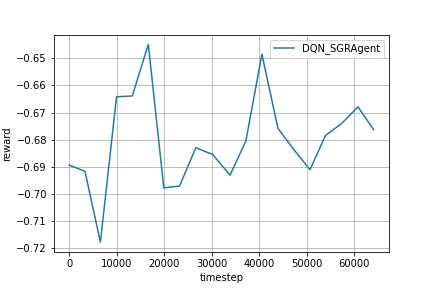

In [ ]:
Image(log_dir + '/sgr_fig.png')

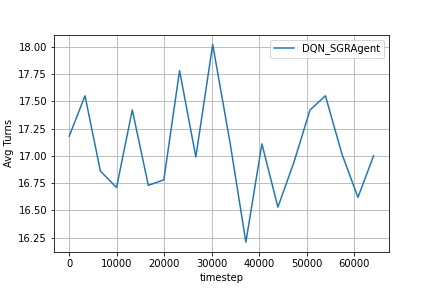

In [ ]:
Image(log_dir + '/sgr_fig2.png')

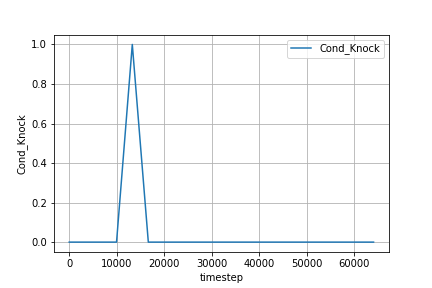

In [ ]:
Image(log_dir + '/sgr_fig3.png')

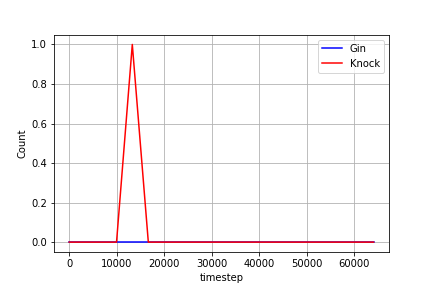

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test6

Test identity without and knock bias, clamped

- 5K samples of the total data

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test6'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
# episode_num = 40000  # mahjong_dqn has 100000
episode_num = 2000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias_clamp_5k.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

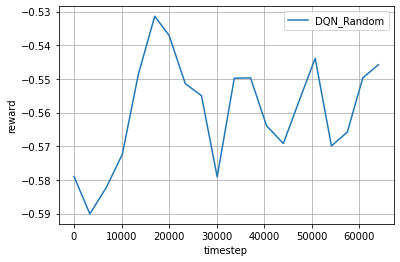

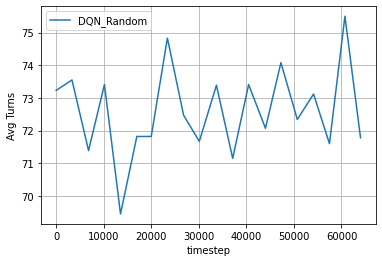

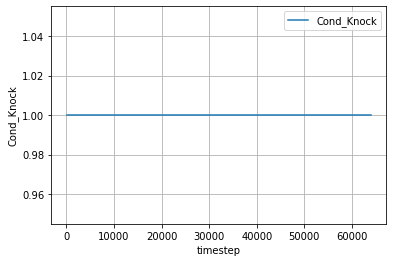

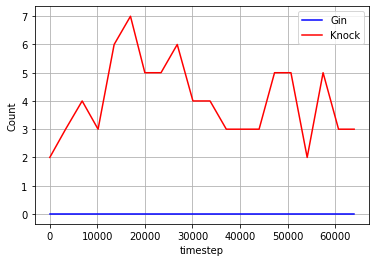

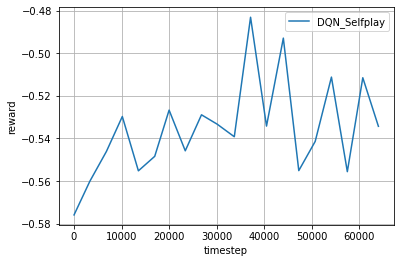

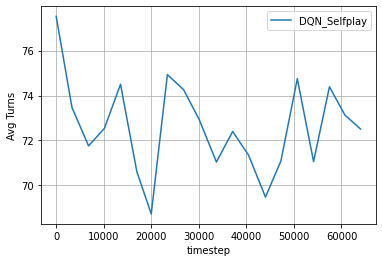

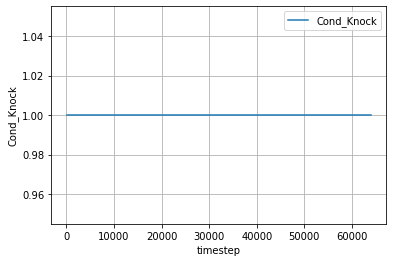

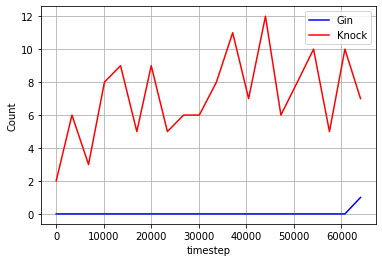

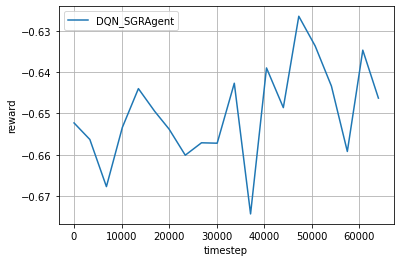

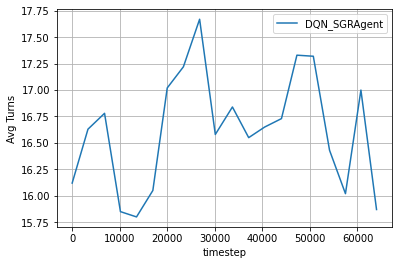

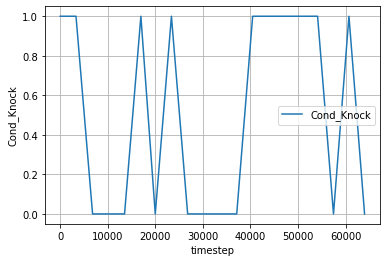

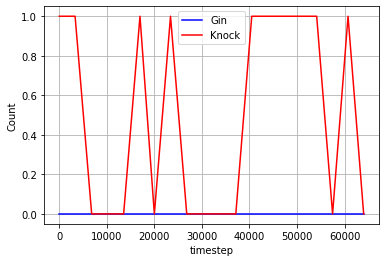

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 10, 'Other': 90, 'Knock_Possible': 10, 'Avg Turns': 71.85}


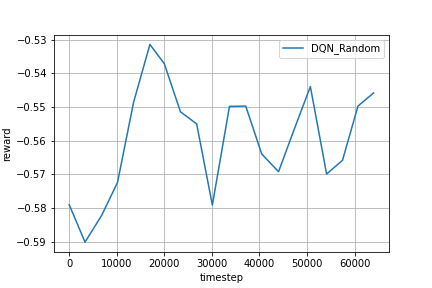

In [ ]:
Image(log_dir + '/rand_fig.png')

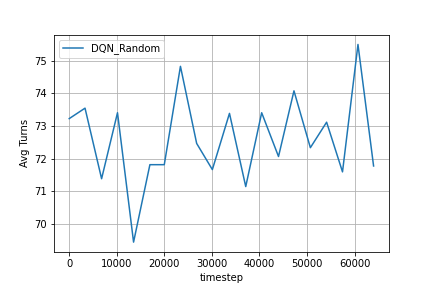

In [ ]:
Image(log_dir + '/rand_fig2.png')

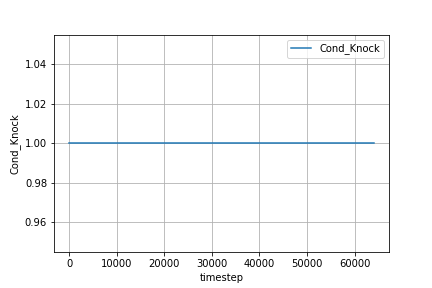

In [ ]:
Image(log_dir + '/rand_fig3.png')

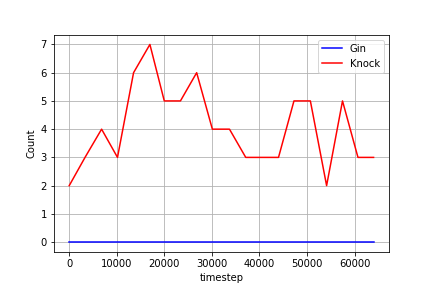

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 9, 'Other': 91, 'Knock_Possible': 9, 'Avg Turns': 71.92}


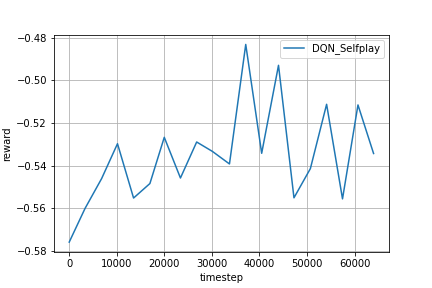

In [ ]:
Image(log_dir + '/self_fig.png')

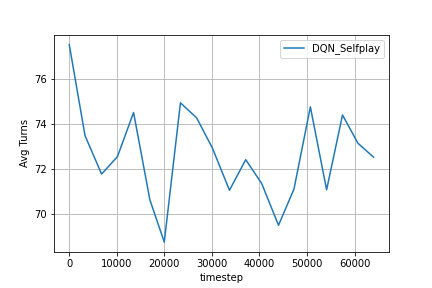

In [ ]:
Image(log_dir + '/self_fig2.png')

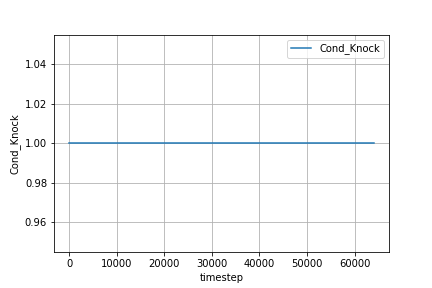

In [ ]:
Image(log_dir + '/self_fig3.png')

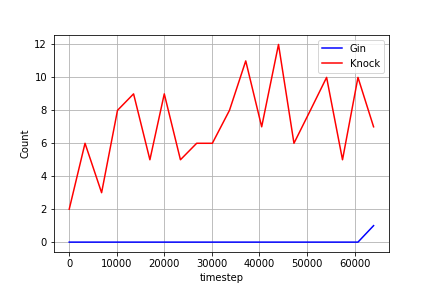

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 1, 'Other': 99, 'Knock_Possible': 1, 'Avg Turns': 16.01}


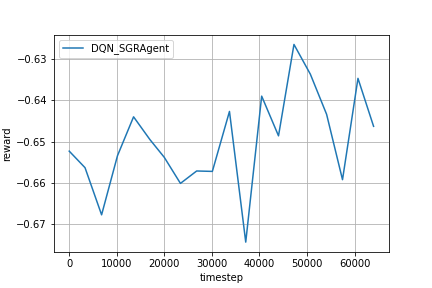

In [ ]:
Image(log_dir + '/sgr_fig.png')

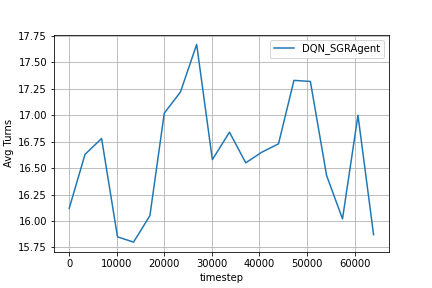

In [ ]:
Image(log_dir + '/sgr_fig2.png')

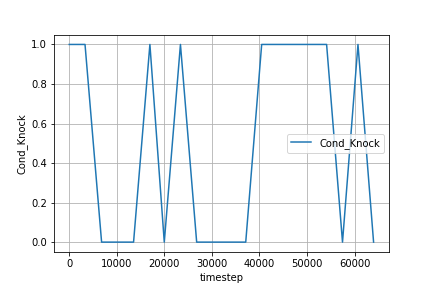

In [ ]:
Image(log_dir + '/sgr_fig3.png')

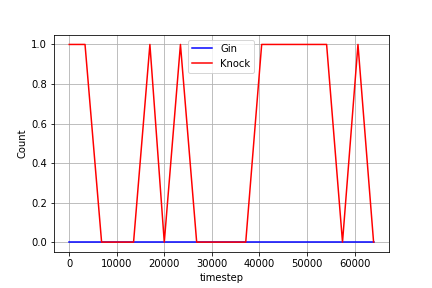

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test7

Test identity without and bias trained, clamped

- 10% of the total data

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test7'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 40000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = False
knock_layer = True
knock_val = 0.02
# knock_val = 0.01
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False


### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_and_bias_clamp_point1.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
pretrained_dict['fc_layers.7.bias'] = model_dict_identity['l1.bias']

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

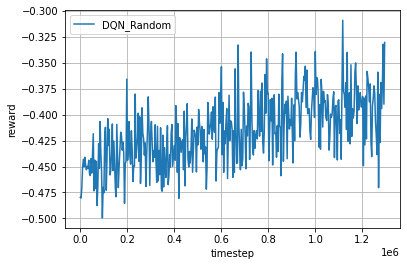

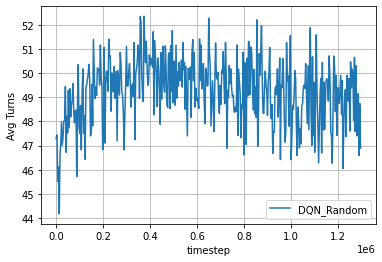

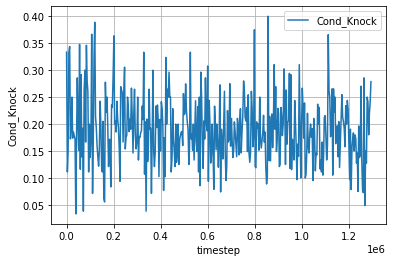

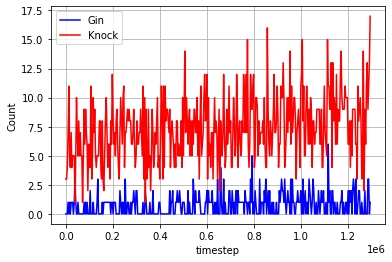

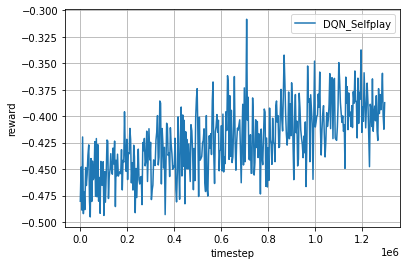

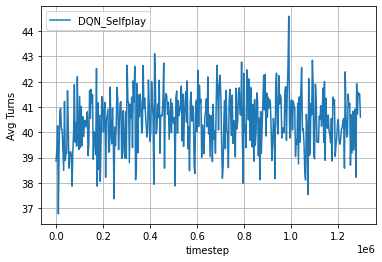

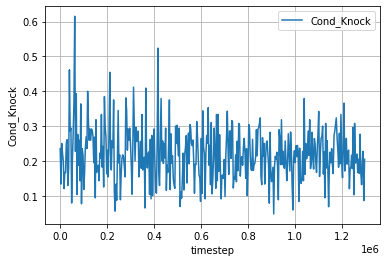

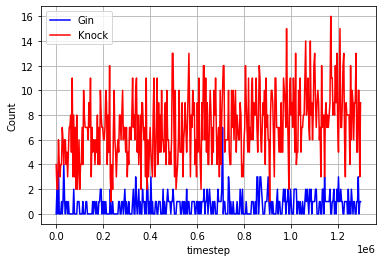

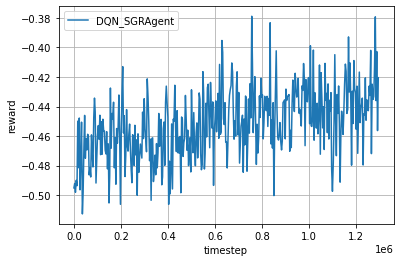

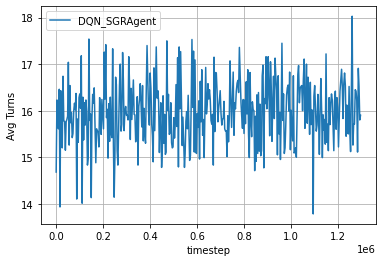

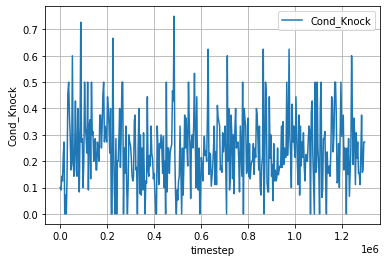

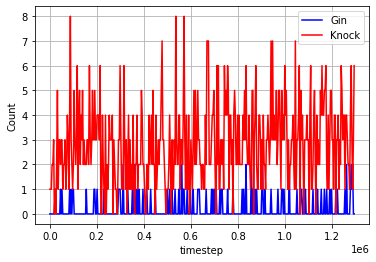

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 3, 'Knock': 11, 'Other': 86, 'Knock_Possible': 48, 'Avg Turns': 47.39}


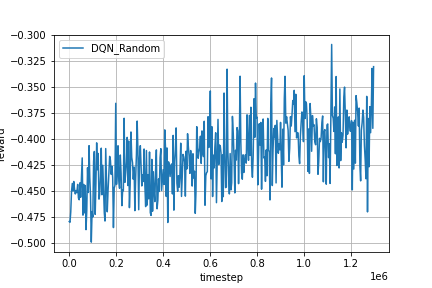

In [ ]:
Image(log_dir + '/rand_fig.png')

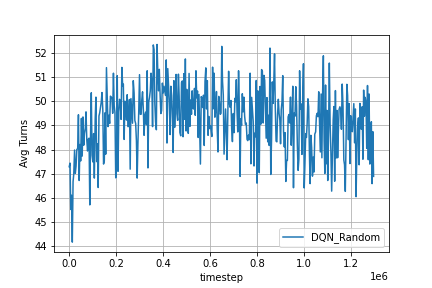

In [ ]:
Image(log_dir + '/rand_fig2.png')

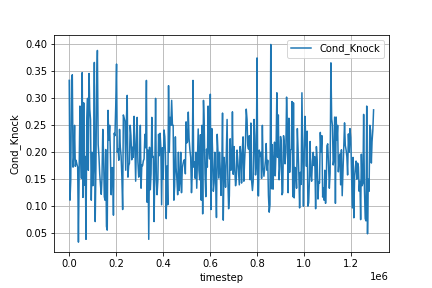

In [ ]:
Image(log_dir + '/rand_fig3.png')

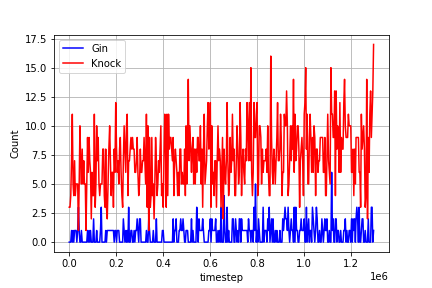

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 6, 'Other': 93, 'Knock_Possible': 47, 'Avg Turns': 42.48}


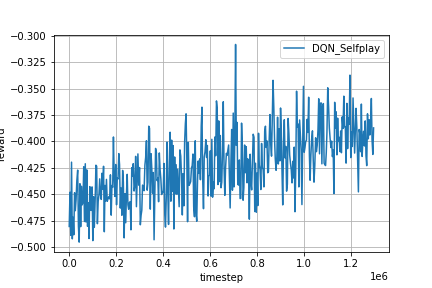

In [ ]:
Image(log_dir + '/self_fig.png')

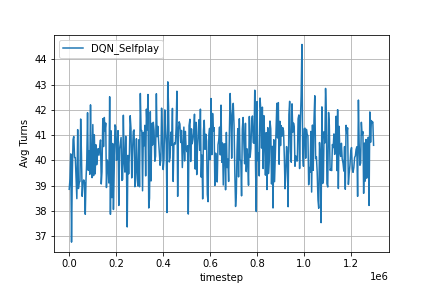

In [ ]:
Image(log_dir + '/self_fig2.png')

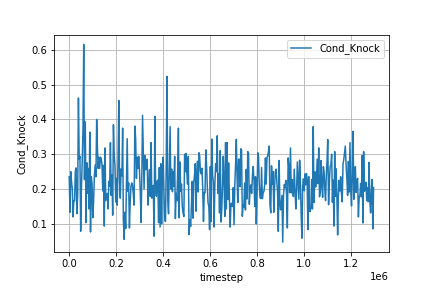

In [ ]:
Image(log_dir + '/self_fig3.png')

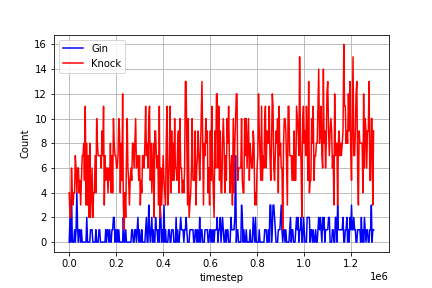

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 5, 'Other': 95, 'Knock_Possible': 14, 'Avg Turns': 14.92}


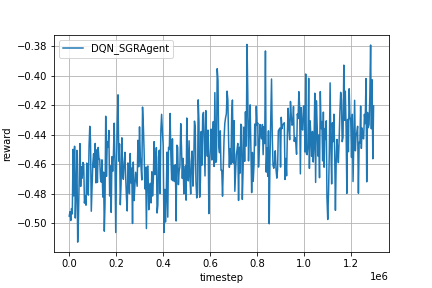

In [ ]:
Image(log_dir + '/sgr_fig.png')

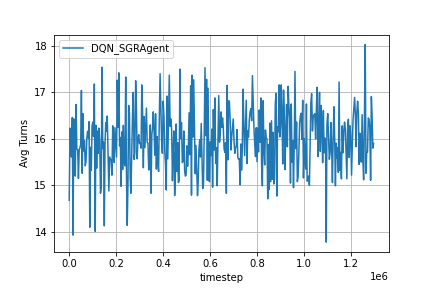

In [ ]:
Image(log_dir + '/sgr_fig2.png')

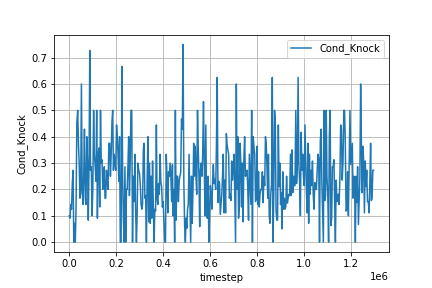

In [ ]:
Image(log_dir + '/sgr_fig3.png')

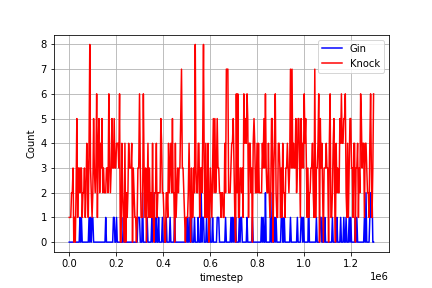

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test8

Test identity without and knock bias, clamped

- 10% of the total data

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test8'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 100000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias_clamp_point1.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

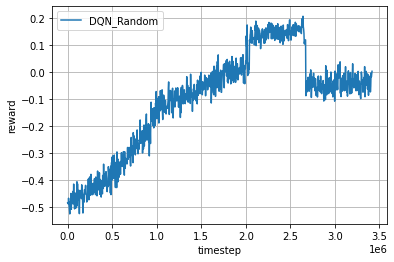

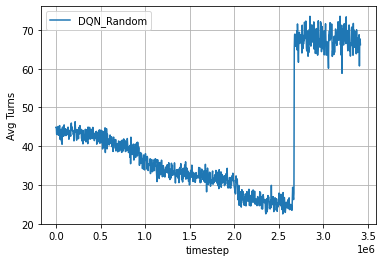

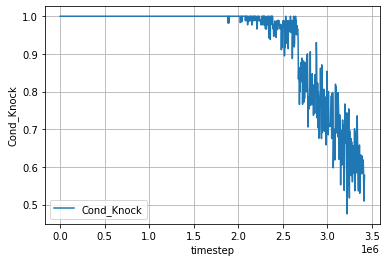

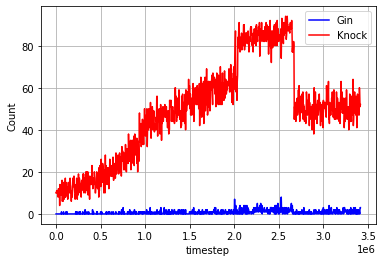

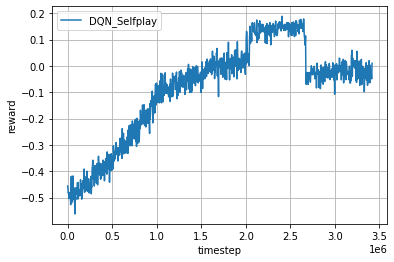

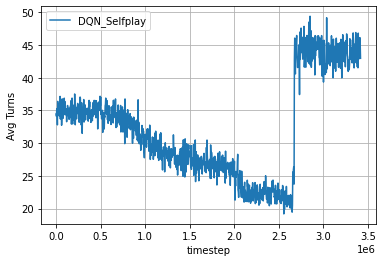

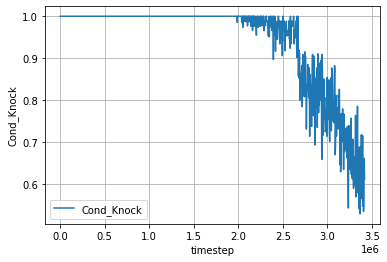

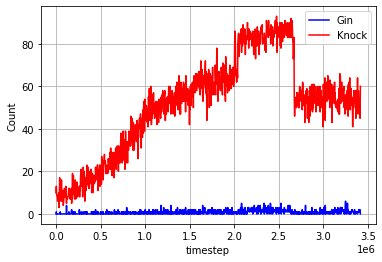

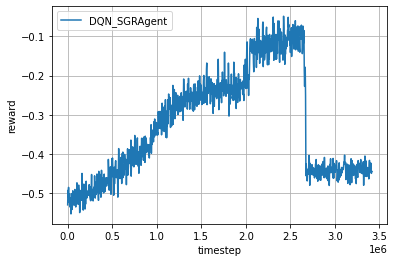

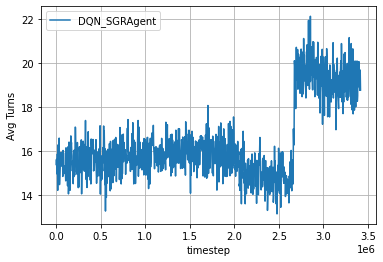

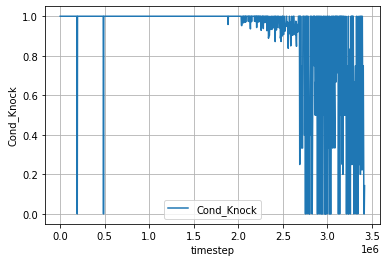

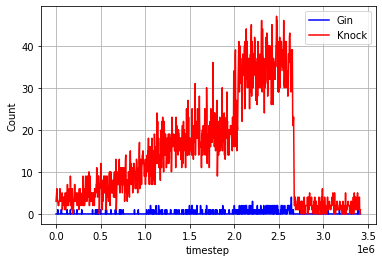

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 2, 'Knock': 52, 'Other': 46, 'Knock_Possible': 92, 'Avg Turns': 66.11}


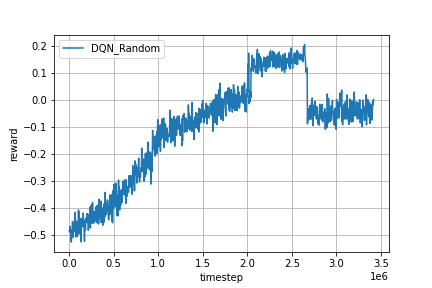

In [ ]:
Image(log_dir + '/rand_fig.png')

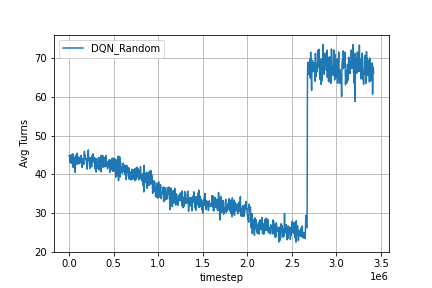

In [ ]:
Image(log_dir + '/rand_fig2.png')

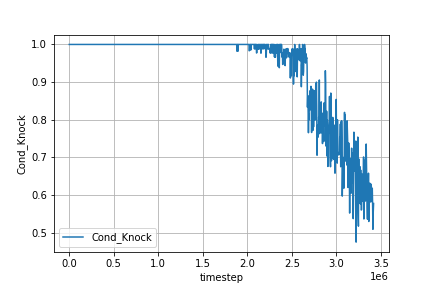

In [ ]:
Image(log_dir + '/rand_fig3.png')

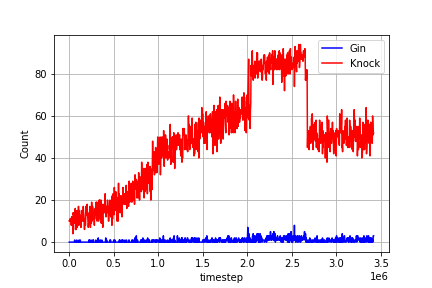

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 3, 'Knock': 38, 'Other': 59, 'Knock_Possible': 66, 'Avg Turns': 48.09}


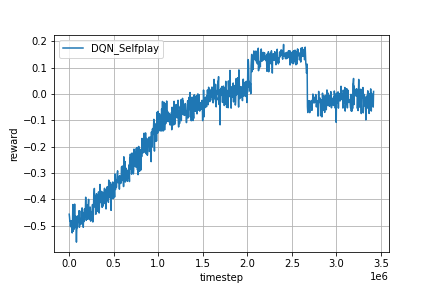

In [ ]:
Image(log_dir + '/self_fig.png')

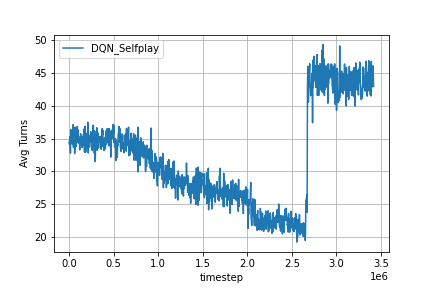

In [ ]:
Image(log_dir + '/self_fig2.png')

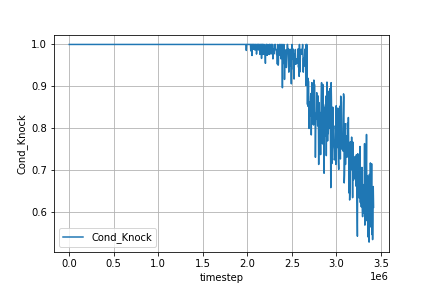

In [ ]:
Image(log_dir + '/self_fig3.png')

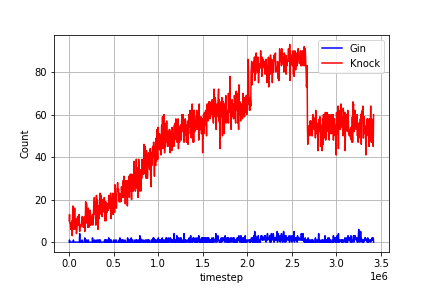

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 3, 'Other': 97, 'Knock_Possible': 5, 'Avg Turns': 18.37}


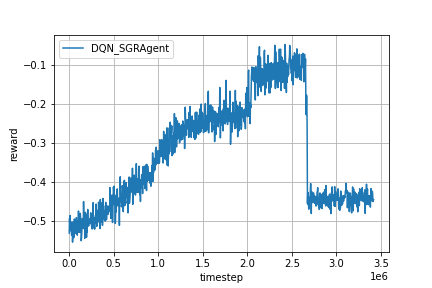

In [ ]:
Image(log_dir + '/sgr_fig.png')

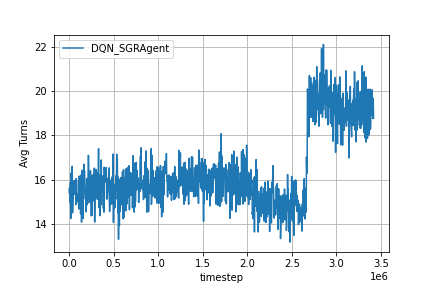

In [ ]:
Image(log_dir + '/sgr_fig2.png')

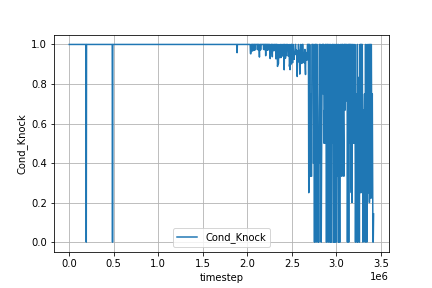

In [ ]:
Image(log_dir + '/sgr_fig3.png')

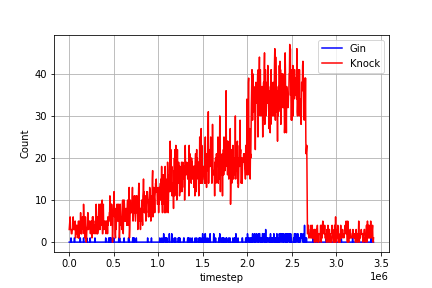

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test9

Test identity without and knock bias, clamped

- 10% of the total data
- LR = 5e-6 instead of 1e-5
- 100K episodes

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test9'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
episode_num = 100000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
# learning_rate = 0.00001 # 1e-5
learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias_clamp_point1.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

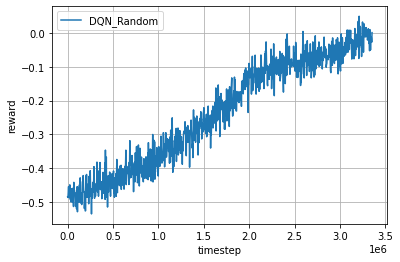

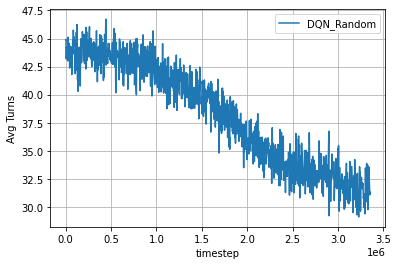

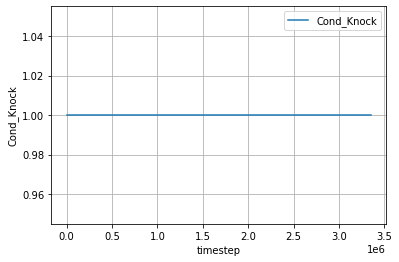

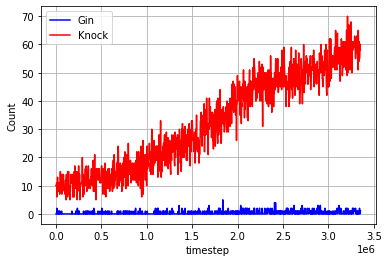

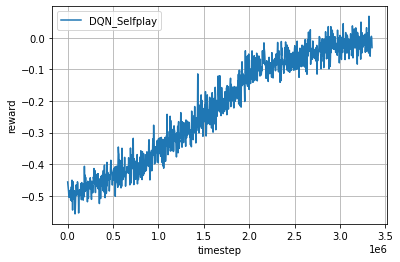

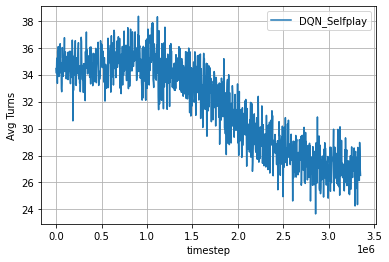

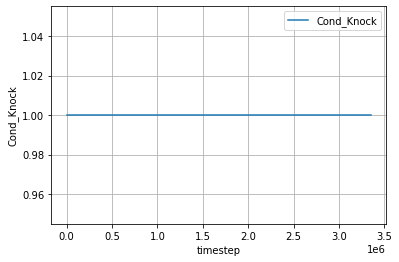

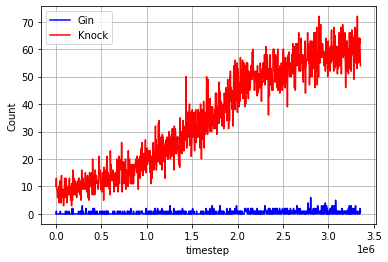

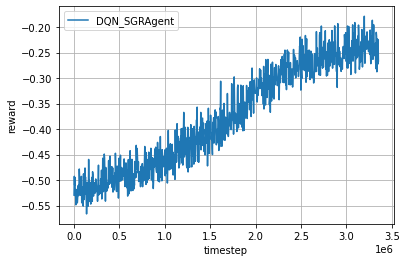

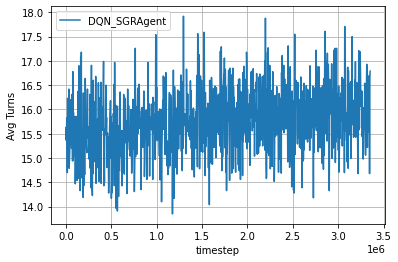

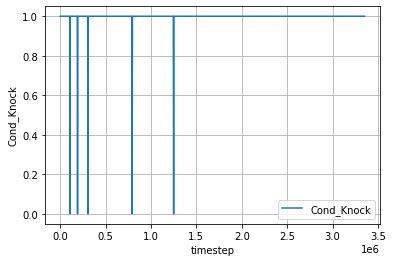

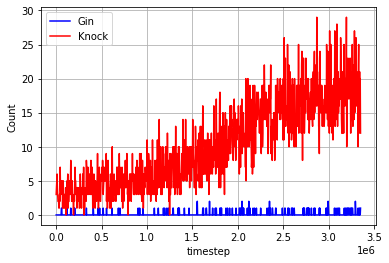

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 66, 'Other': 34, 'Knock_Possible': 66, 'Avg Turns': 31.09}


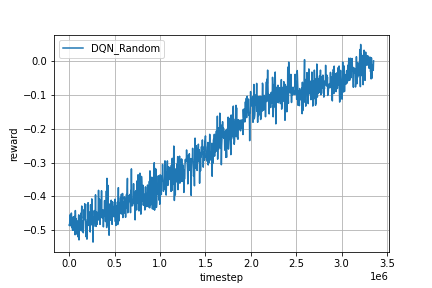

In [ ]:
Image(log_dir + '/rand_fig.png')

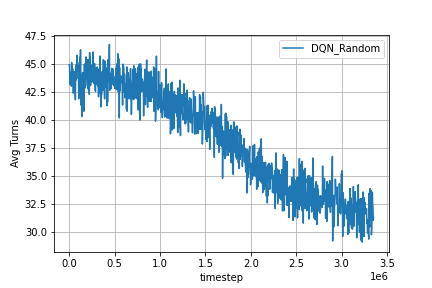

In [ ]:
Image(log_dir + '/rand_fig2.png')

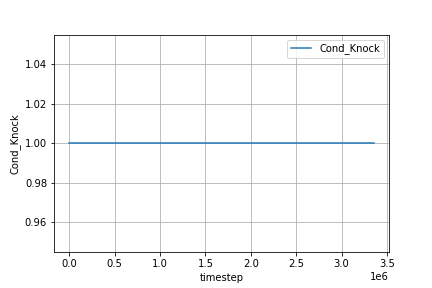

In [ ]:
Image(log_dir + '/rand_fig3.png')

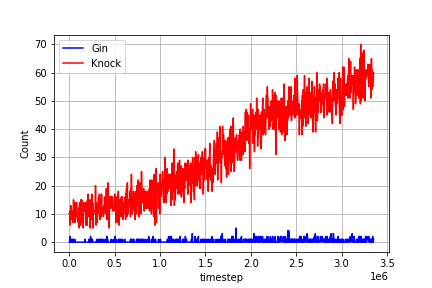

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 62, 'Other': 38, 'Knock_Possible': 62, 'Avg Turns': 26.71}


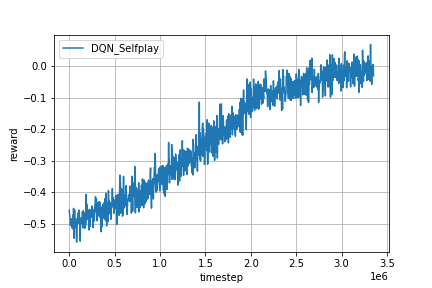

In [ ]:
Image(log_dir + '/self_fig.png')

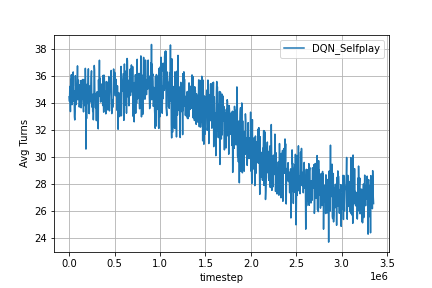

In [ ]:
Image(log_dir + '/self_fig2.png')

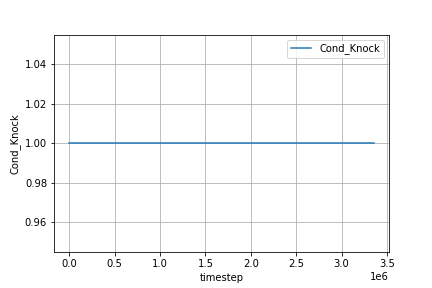

In [ ]:
Image(log_dir + '/self_fig3.png')

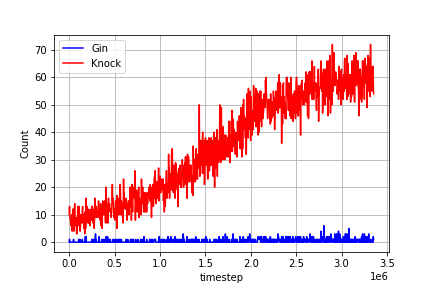

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 26, 'Other': 73, 'Knock_Possible': 26, 'Avg Turns': 15.69}


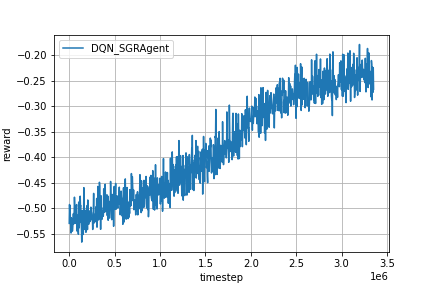

In [ ]:
Image(log_dir + '/sgr_fig.png')

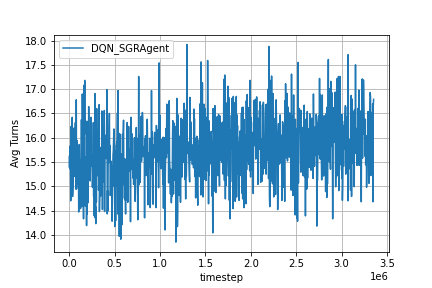

In [ ]:
Image(log_dir + '/sgr_fig2.png')

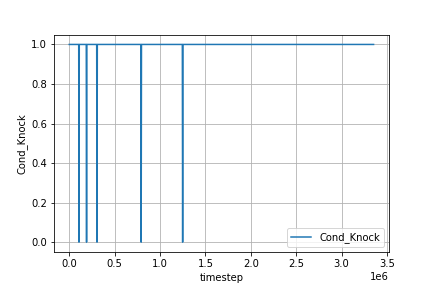

In [ ]:
Image(log_dir + '/sgr_fig3.png')

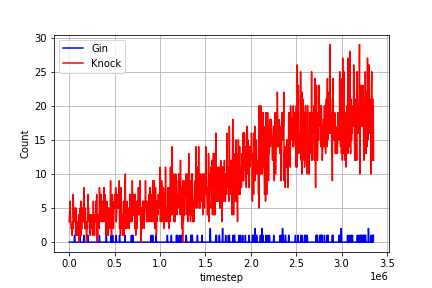

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test10

Test identity without and knock bias, clamped

- 10% of the total data
- LR = 5e-6 instead of 1e-5
- 120K episodes

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test10'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
# episode_num = 100000  # mahjong_dqn has 100000
episode_num = 120000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
# learning_rate = 0.00001 # 1e-5
learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias_clamp_point1.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num//2):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

Streaming output truncated to the last 5000 lines.
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  1490079
  reward       |  -0.31180000000000024
  Avg Turns    |  34.51
  Cond_Knock   |  1.0
  Gin: 1 | Knock: 21 | Other: 78
----------------------------------------

SGRAgent:

----------------------------------------
  timestep     |  1490079
  reward       |  -0.44780000000000003
  Avg Turns    |  15.2
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 5 | Other: 95
----------------------------------------
INFO - Agent dqn, step 724760, rl-loss: 0.02541758492588997
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  1493515
  reward       |  -0.2382000000000002
  Avg Turns    |  39.16
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 33 | Other: 67
----------------------------------------

Selfplay:

----------------------------------------
  timestep     

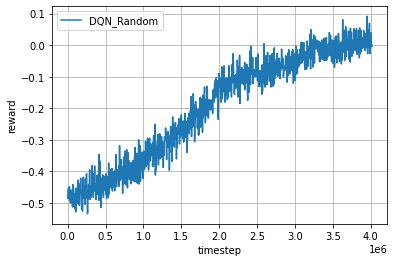

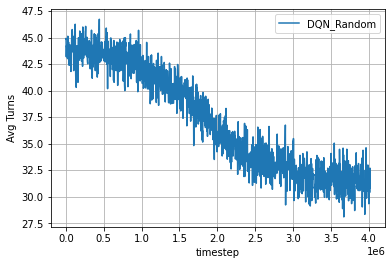

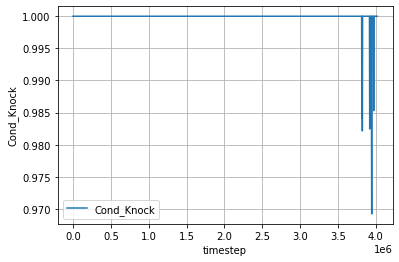

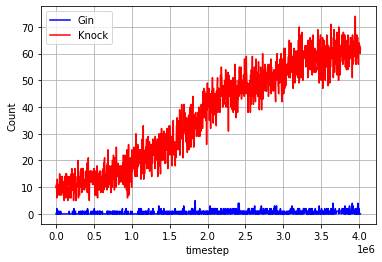

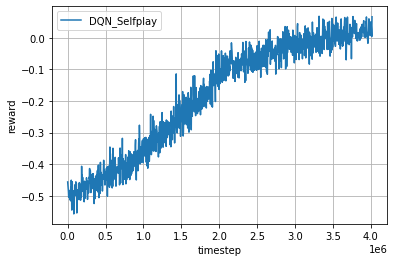

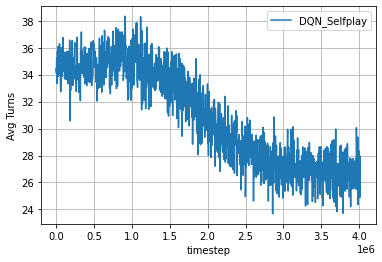

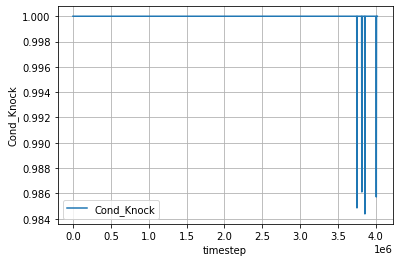

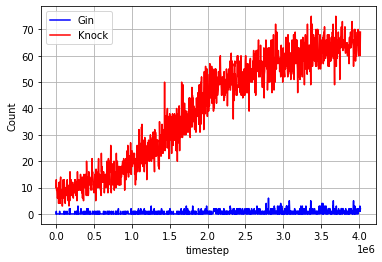

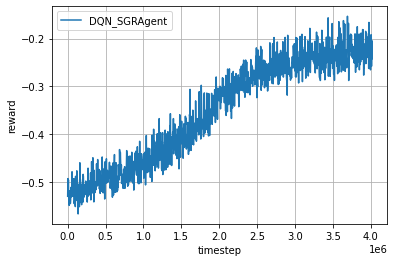

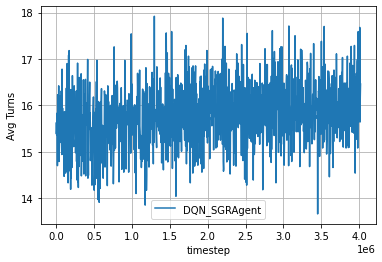

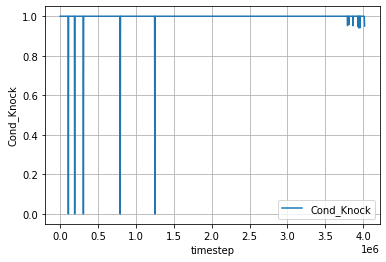

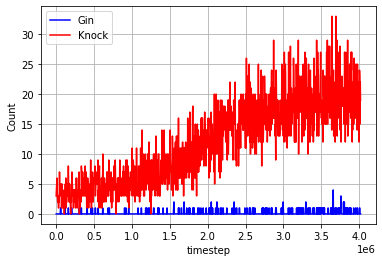

In [ ]:
# Training Loop 2
for episode in range(episode_num//2, episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 68, 'Other': 32, 'Knock_Possible': 68, 'Avg Turns': 30.56}


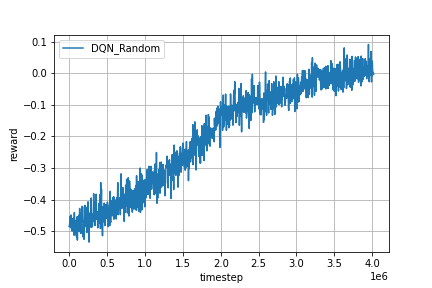

In [ ]:
Image(log_dir + '/rand_fig.png')

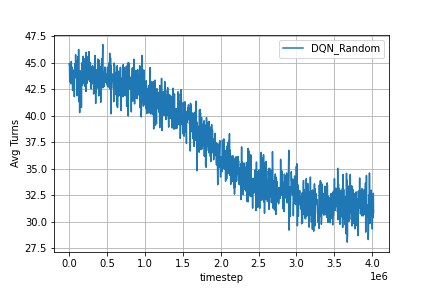

In [ ]:
Image(log_dir + '/rand_fig2.png')

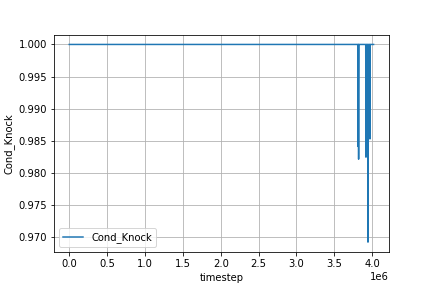

In [ ]:
Image(log_dir + '/rand_fig3.png')

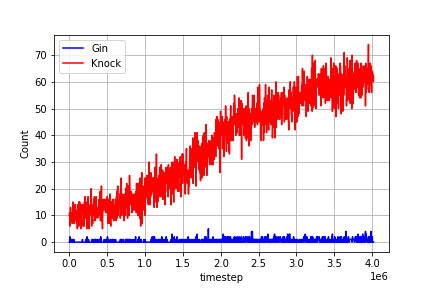

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 1, 'Knock': 63, 'Other': 36, 'Knock_Possible': 63, 'Avg Turns': 24.95}


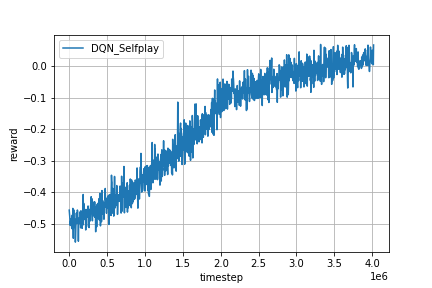

In [ ]:
Image(log_dir + '/self_fig.png')

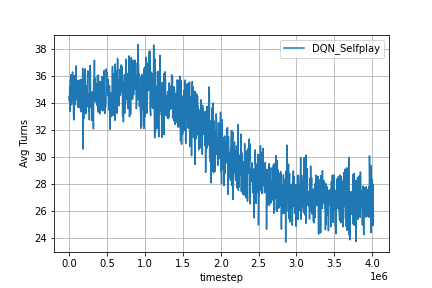

In [ ]:
Image(log_dir + '/self_fig2.png')

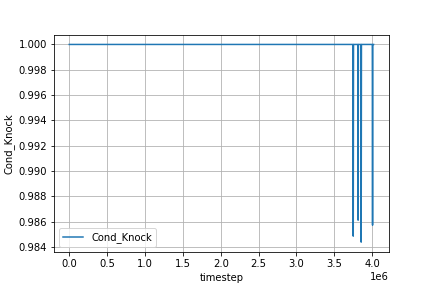

In [ ]:
Image(log_dir + '/self_fig3.png')

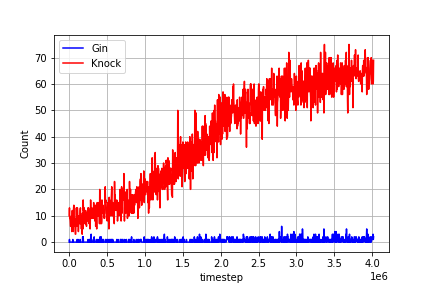

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 17, 'Other': 83, 'Knock_Possible': 17, 'Avg Turns': 16.26}


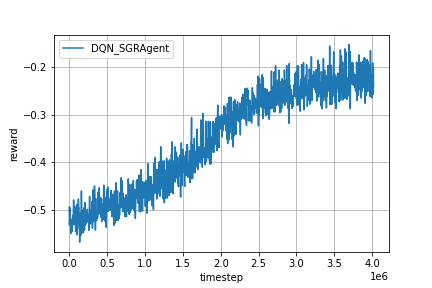

In [ ]:
Image(log_dir + '/sgr_fig.png')

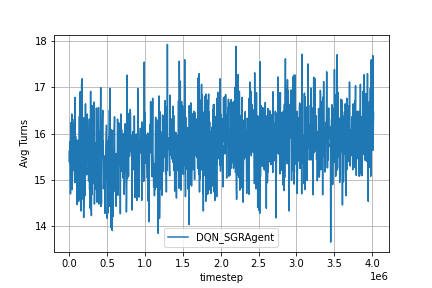

In [ ]:
Image(log_dir + '/sgr_fig2.png')

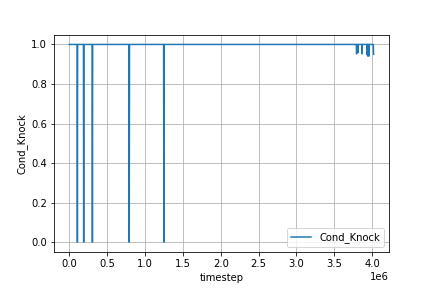

In [ ]:
Image(log_dir + '/sgr_fig3.png')

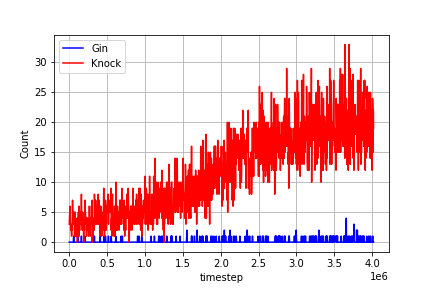

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test11

Test identity without and knock bias, clamped

- 10% of the total data
- LR = 5e-6 instead of 1e-5
- 180K episodes

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test11'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
# episode_num = 100000  # mahjong_dqn has 100000
episode_num = 180000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
# learning_rate = 0.00001 # 1e-5
learning_rate = 5e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias_clamp_point1.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num//3):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

Streaming output truncated to the last 5000 lines.
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  1490079
  reward       |  -0.31180000000000024
  Avg Turns    |  34.51
  Cond_Knock   |  1.0
  Gin: 1 | Knock: 21 | Other: 78
----------------------------------------

SGRAgent:

----------------------------------------
  timestep     |  1490079
  reward       |  -0.44780000000000003
  Avg Turns    |  15.2
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 5 | Other: 95
----------------------------------------
INFO - Agent dqn, step 724760, rl-loss: 0.02541758492588997
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  1493515
  reward       |  -0.2382000000000002
  Avg Turns    |  39.16
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 33 | Other: 67
----------------------------------------

Selfplay:

----------------------------------------
  timestep     

In [ ]:
# Training Loop 2
for episode in range(episode_num//3, 2*episode_num//3):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))


Streaming output truncated to the last 5000 lines.
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  3504924
  reward       |  -0.0008000000000000051
  Avg Turns    |  27.11
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 64 | Other: 36
----------------------------------------

SGRAgent:

----------------------------------------
  timestep     |  3504924
  reward       |  -0.21520000000000014
  Avg Turns    |  15.64
  Cond_Knock   |  1.0
  Gin: 1 | Knock: 19 | Other: 80
----------------------------------------
INFO - Agent dqn, step 1702000, rl-loss: 0.02224530652165413
INFO - Copied model parameters to target network.
INFO - Agent dqn, step 1702740, rl-loss: 0.014816595241427422
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  3508481
  reward       |  0.014999999999999993
  Avg Turns    |  31.08
  Cond_Knock   |  1.0
  Gin: 1 | Knock: 62 | O

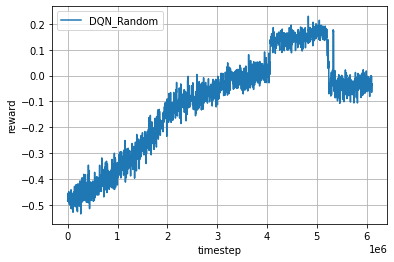

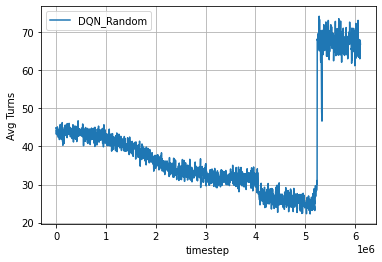

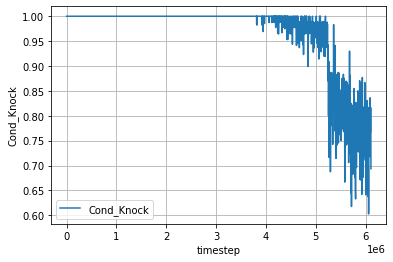

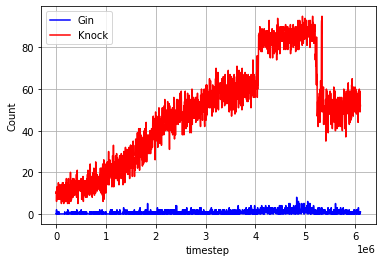

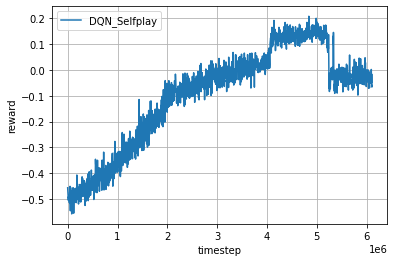

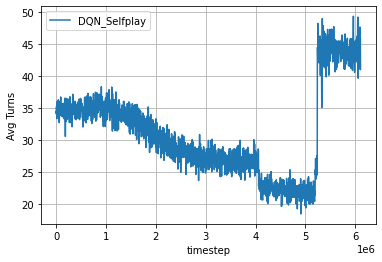

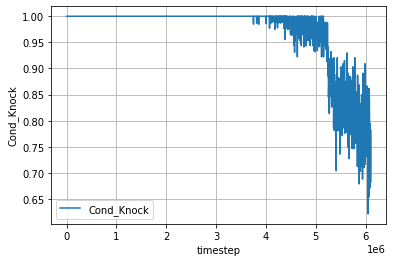

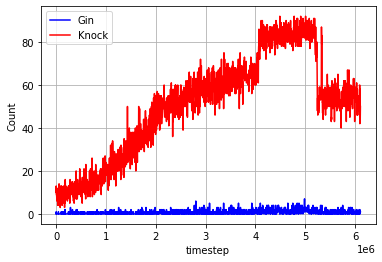

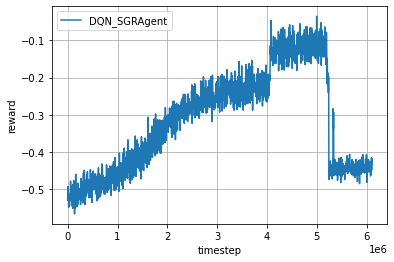

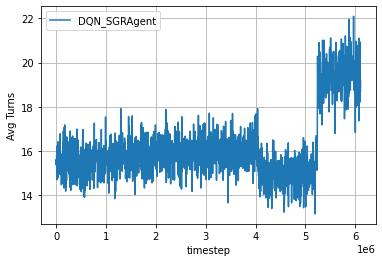

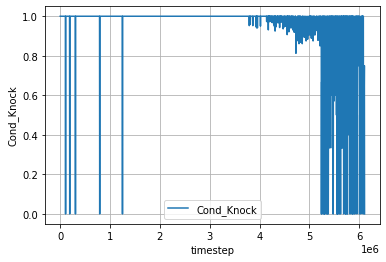

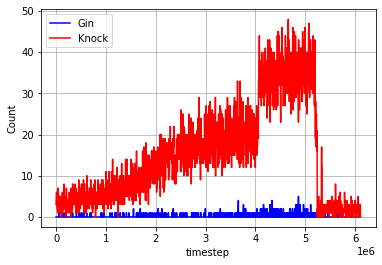

In [ ]:
# Training Loop 3
for episode in range(2*episode_num//3, episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 57, 'Other': 43, 'Knock_Possible': 80, 'Avg Turns': 62.54}


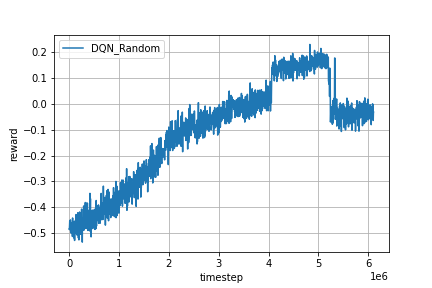

In [ ]:
Image(log_dir + '/rand_fig.png')

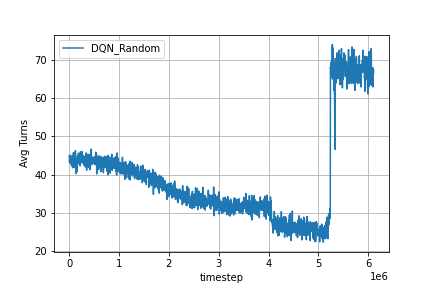

In [ ]:
Image(log_dir + '/rand_fig2.png')

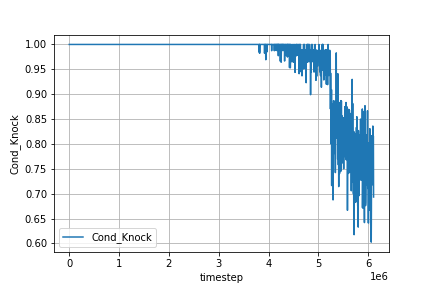

In [ ]:
Image(log_dir + '/rand_fig3.png')

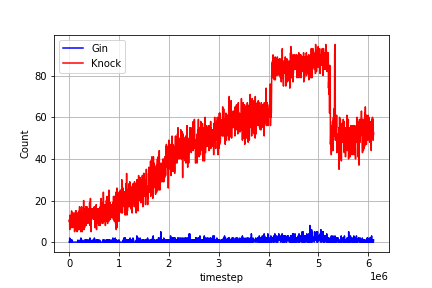

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 54, 'Other': 46, 'Knock_Possible': 68, 'Avg Turns': 42.72}


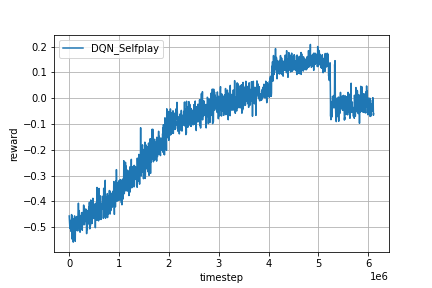

In [ ]:
Image(log_dir + '/self_fig.png')

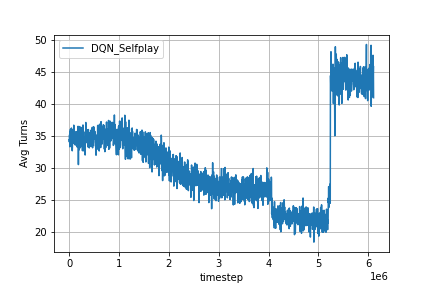

In [ ]:
Image(log_dir + '/self_fig2.png')

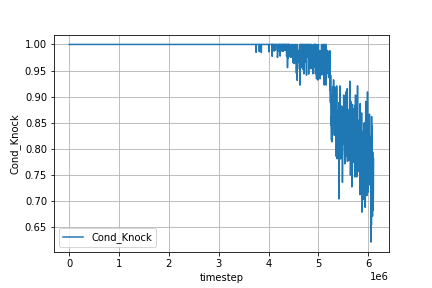

In [ ]:
Image(log_dir + '/self_fig3.png')

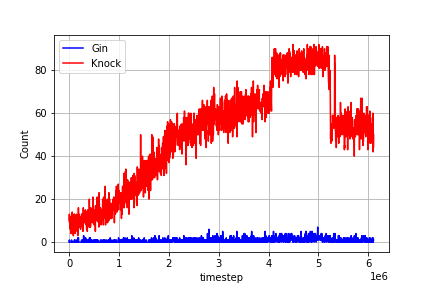

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

{'Gin': 0, 'Knock': 2, 'Other': 98, 'Knock_Possible': 3, 'Avg Turns': 20.54}


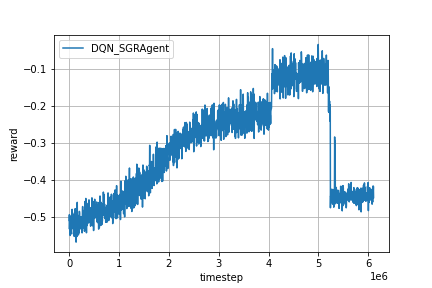

In [ ]:
Image(log_dir + '/sgr_fig.png')

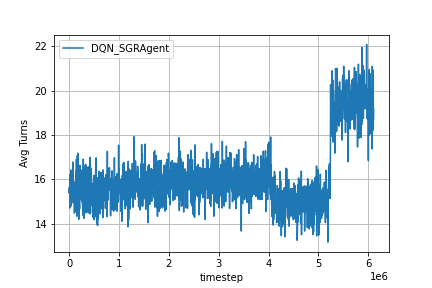

In [ ]:
Image(log_dir + '/sgr_fig2.png')

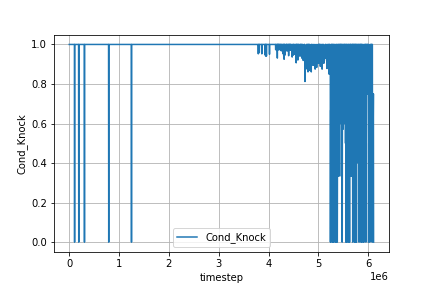

In [ ]:
Image(log_dir + '/sgr_fig3.png')

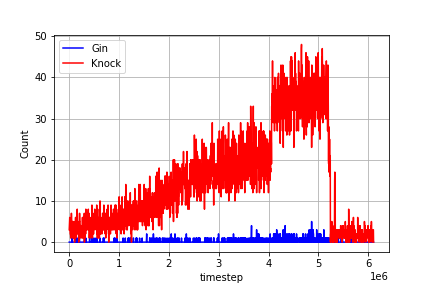

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test12

Test identity without and knock bias, clamped

- 10% of the total data
- LR = 5e-7 instead of 1e-5
- 172K episodes

### Parameters

In [ ]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test12'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
# episode_num = 100000  # mahjong_dqn has 100000
episode_num = 240000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
# learning_rate = 0.00001 # 1e-5
# learning_rate = 5e-6
learning_rate = 5e-7
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [ ]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

In [ ]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [ ]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [ ]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [ ]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias_clamp_point1.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [ ]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [ ]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

In [ ]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num//4):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

In [ ]:
# Training Loop 2
for episode in range(episode_num//4, 2*episode_num//4):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

In [ ]:
# Training Loop 3
for episode in range(2*episode_num//4, 3*episode_num//4):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

In [ ]:
print(episode)

172000


172000
./plots/dqn/identity/test12/rand_performance.csv
./plots/dqn/identity/test12/rand_performance.csv
./plots/dqn/identity/test12/rand_performance.csv
./plots/dqn/identity/test12/rand_performance.csv
./plots/dqn/identity/test12/self_performance.csv
./plots/dqn/identity/test12/self_performance.csv
./plots/dqn/identity/test12/self_performance.csv
./plots/dqn/identity/test12/self_performance.csv
./plots/dqn/identity/test12/sgr_performance.csv
./plots/dqn/identity/test12/sgr_performance.csv
./plots/dqn/identity/test12/sgr_performance.csv
./plots/dqn/identity/test12/sgr_performance.csv


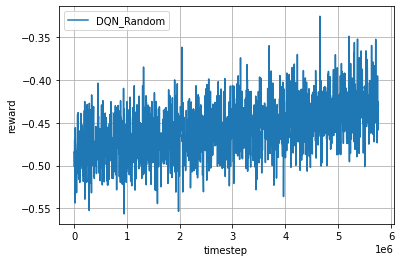

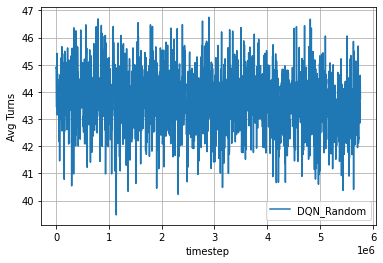

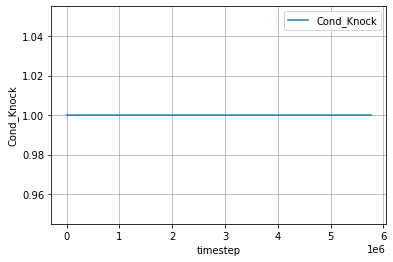

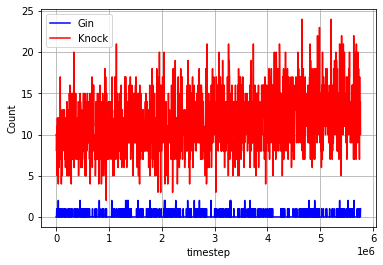

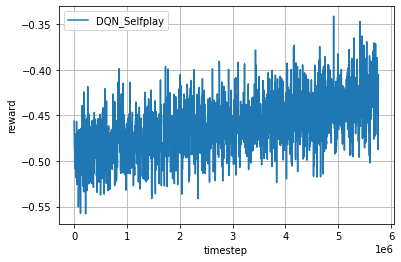

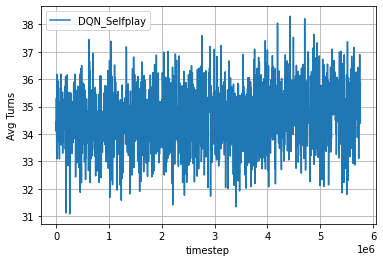

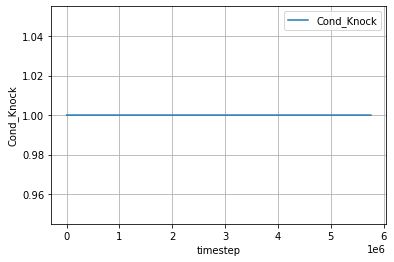

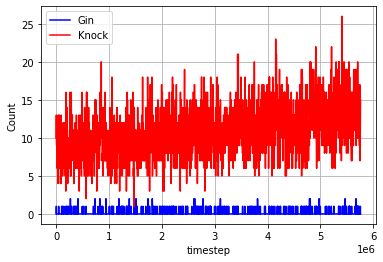

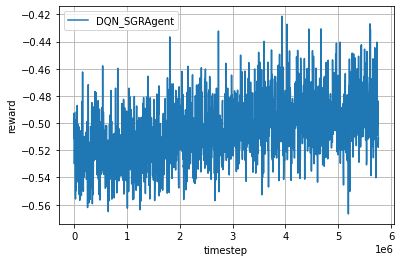

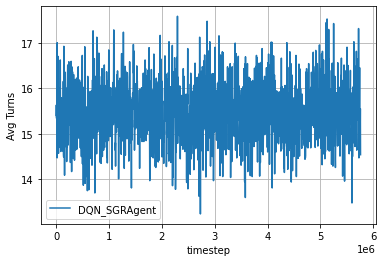

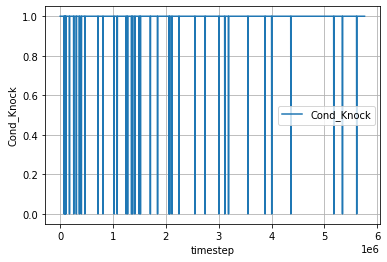

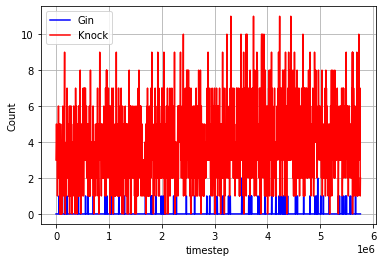

In [ ]:
# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

In [ ]:
# Training Loop 4
for episode in range(3*episode_num//4, episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

In [ ]:
Image(log_dir + '/rand_fig.png')

In [ ]:
Image(log_dir + '/rand_fig2.png')

In [ ]:
Image(log_dir + '/rand_fig3.png')

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

In [ ]:
Image(log_dir + '/self_fig.png')

In [ ]:
Image(log_dir + '/self_fig2.png')

In [ ]:
Image(log_dir + '/self_fig3.png')

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

In [ ]:
Image(log_dir + '/sgr_fig.png')

In [ ]:
Image(log_dir + '/sgr_fig2.png')

In [ ]:
Image(log_dir + '/sgr_fig3.png')

In [ ]:
Image(log_dir + '/sgr_fig4.png')

## test13

Test identity without and knock bias, clamped

- 10% of the total data
- LR = 1e-6 instead of 1e-5
- 240K episodes

### Parameters

In [6]:
# Pretrain model selection
state = 'all'
action = 'all'
model_name = '{}/models/{}/{}/all_states_all_actions_2hl_extra_knock_data_80K/model.pt'.format(pth,state,action)
dqn_model_name = 'test13'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
isDQN = False

# mlp layers 
mlp_layers = [520, 520, 110]

# Set the iterations numbers and how frequently we evaluate/save plot
evaluate_every = 100
evaluate_num = 100  # mahjong_dqn has 1000
# episode_num = 100000  # mahjong_dqn has 100000
episode_num = 240000  # mahjong_dqn has 100000

# learning rate
# learning_rate = 0.00005
# learning_rate = 0.00001 # 1e-5
learning_rate = 1e-6
# learning_rate = 5e-9

# replay_memory_size
# default: 20000
replay_memory_size = 20000

# The initial memory size
# default: 100
memory_init_size = 2000

# default: 32
# batch_size = 1024
batch_size = 64

# update_target_estimator_every
# default: 1000
update_target_estimator_every = 1000

# Train the agent every X steps
train_every = 10

# enable top layer, copy top layer weights, freeze_layers
top_layer = False
copy_top = True
# freeze_layers = False
freeze_layers = True

# Batch Normalization
batch_norm = False

# Knock Layer
knock_layer = True
knock_val = 1

# environment configs
# payoff_fnc = get_payoff_gin_rummy_v8
# cfg = {'seed': 0, 'payoff_fnc': payoff_fnc}
# cfg = {'seed': 0, 'is_always_knock': True}
cfg = {'seed': 0}

### Environment Initialization

In [7]:
from tensorflow.keras.backend import clear_session
clear_session()

# Make environments
env = rlcard.make('gin-rummy', config=cfg)

random_env = rlcard.make('gin-rummy', config=cfg)
selfplay_env = rlcard.make('gin-rummy', config=cfg)
SGRAgent_env = rlcard.make('gin-rummy', config=cfg)
env.game.settings.print_settings()

# The paths for saving the logs and learning curves
log_dir = './plots/dqn/{}/{}'.format(dir, dqn_model_name)

# Set a global seed
set_global_seed(0)

random_agent = RandomAgent(action_num=random_env.action_num)
SGRAgent = SimpleGinRummyAgent(action_num=SGRAgent_env.action_num)

agent = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

agent2 = DQNAgent(scope='dqn',
                 replay_memory_size=replay_memory_size,
                 replay_memory_init_size=memory_init_size,       # default: 100
                 update_target_estimator_every=update_target_estimator_every,
                 discount_factor=0.99,
                 epsilon_start=1.0,
                 epsilon_end=0.1,
                 epsilon_decay_steps=20000,
                 batch_size=batch_size,                      # default: 32
                 action_num=env.action_num,
                 state_shape=env.state_shape,
                 train_every=train_every,            # default: 1
                 mlp_layers=mlp_layers,
                 learning_rate=learning_rate,        # default: 0.00005 (5e-5)
                 device=device,
                 batch_norm=batch_norm,
                 knock_layer=knock_layer,
                 top_layer=top_layer)

# Training env
env.set_agents([agent, SGRAgent])

# random env
random_env.set_agents([agent, random_agent])

# selfplay env
selfplay_env.set_agents([agent, agent2])

# SGRAgent env 
SGRAgent_env.set_agents([agent, SGRAgent])

# Init a Logger to plot the learning curve
# logger = Logger(log_dir)
logger_rand = Logger(log_dir, env='rand_')
logger_self = Logger(log_dir, env='self_')
logger_sgr = Logger(log_dir, env='sgr_')

========== Settings ==========
scorer_name=GinRummyScorer
dealer_for_round=DealerForRound.Random
stockpile_dead_card_count=2
going_out_deadwood_count=10
max_drawn_card_count=52
is_allowed_knock=True
is_allowed_gin=True
is_allowed_pick_up_discard=True
is_allowed_to_discard_picked_up_card=False
is_always_knock=False
is_south_never_knocks=False



### Load Pretrained Weights

In [8]:
checkpoint = torch.load(model_name, map_location=device)
load_checkpoint(checkpoint, agent)
load_checkpoint(checkpoint, agent2)

In [9]:
# fix layer freezing due to loading
agent.q_estimator.qnet.fc_layers[1].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[1].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[3].bias.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].weight.requires_grad = False
agent.q_estimator.qnet.fc_layers[5].bias.requires_grad = False
try:
    agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = False
    agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = False
except:
    pass

In [10]:
# Reload the network so the copy is shallow instead of deep
pretrained_dict = {}
model_dict = agent.q_estimator.qnet.fc_layers.state_dict()
curr_layer = 1
for i in range(len(mlp_layers) + int(top_layer) + int(knock_layer)):
    pretrained_dict['fc_layers.{}.weight'.format(curr_layer)] = model_dict['{}.weight'.format(2*i+1)]
    pretrained_dict['fc_layers.{}.bias'.format(curr_layer)] = model_dict['{}.bias'.format(2*i+1)]
    curr_layer += 2

In [11]:
# Set new knock layer to identity layer
model_dict_identity = torch.load('{}/models/identity/identity_no_bias_clamp_point1.pth'.format(pth), map_location=device)
pretrained_dict['fc_layers.7.weight'] = model_dict_identity['l1.weight']
knock_probs = np.ones(110)*knock_val
knock_probs[0:58] = 0
pretrained_dict['fc_layers.7.bias'] = torch.tensor(knock_probs, device=device)

In [12]:
# load pretrained weights
agent.q_estimator.qnet.load_state_dict(pretrained_dict)
agent.target_estimator.qnet.load_state_dict(pretrained_dict)
agent2.q_estimator.qnet.load_state_dict(pretrained_dict)
agent2.target_estimator.qnet.load_state_dict(pretrained_dict)

<All keys matched successfully>

In [13]:
# unfreeze identity layer
agent.q_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].weight.requires_grad = True
agent.q_estimator.qnet.fc_layers[7].bias.requires_grad = True
agent.target_estimator.qnet.fc_layers[7].bias.requires_grad = True

### Train

#### Training Loop

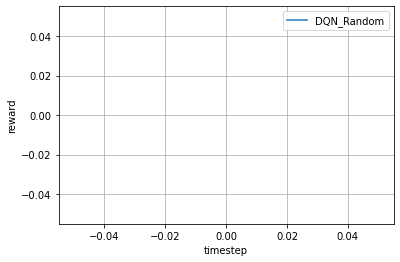

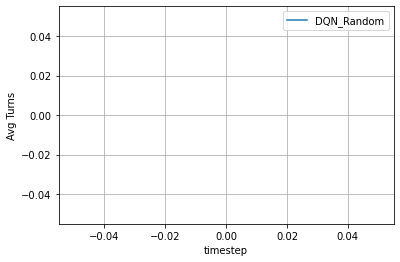

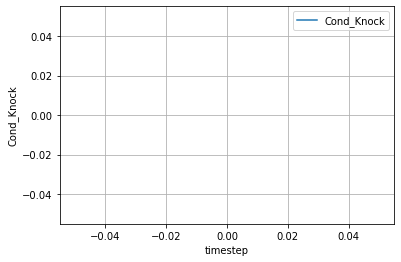

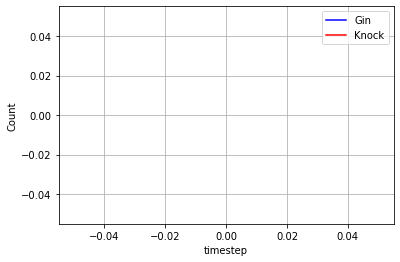

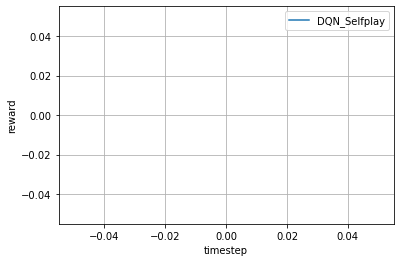

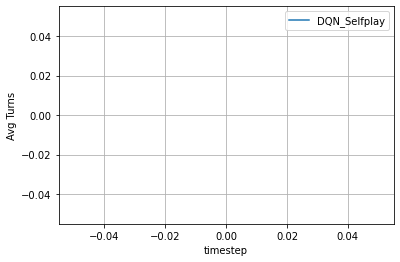

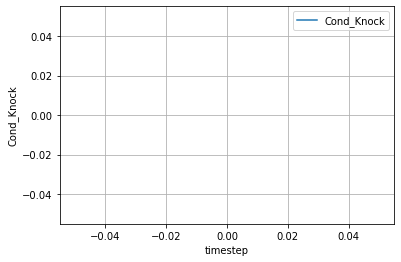

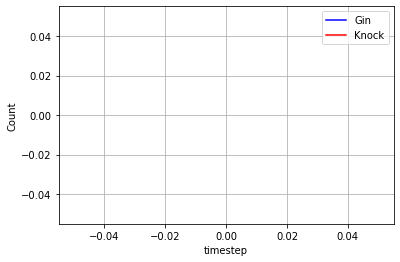

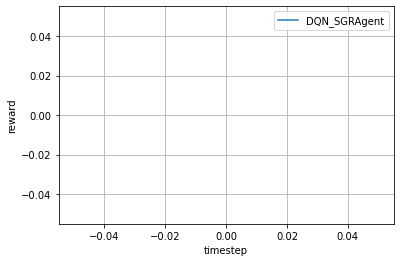

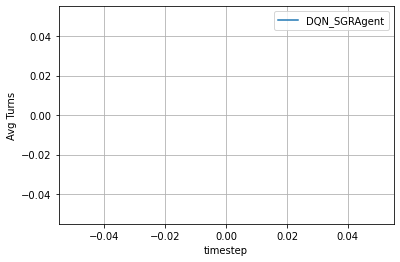

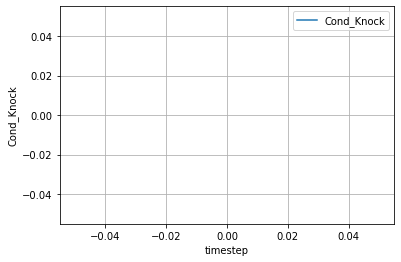

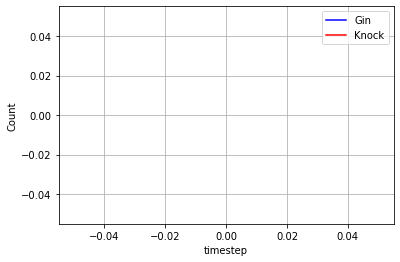

In [14]:
# Save model prior to training
save_dir = 'models/dqn/{}/{}'.format(dir, dqn_model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
state_dict = agent.get_state_dict()
torch.save(state_dict, os.path.join(save_dir, 'model_pretrain.pth'))

max_reward_rand, max_reward_self, max_reward_sgr = -1, -1, -1
max_knock_rand, max_knock_self, max_knock_sgr = 0, 0, 0

# Training Loop
for episode in range(episode_num//4):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

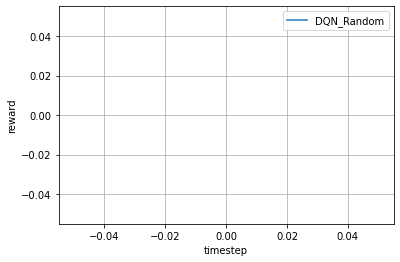

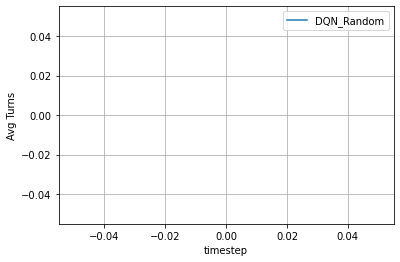

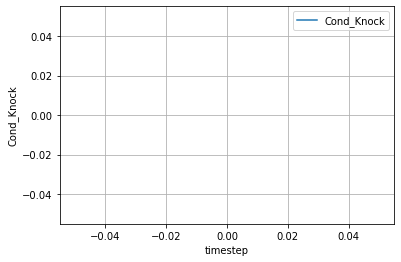

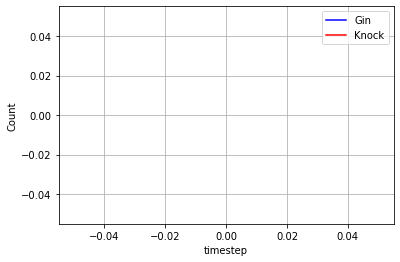

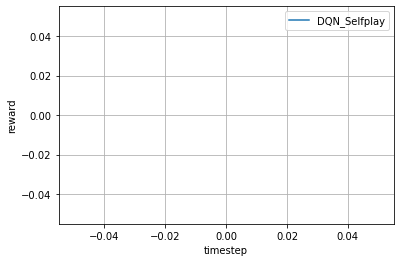

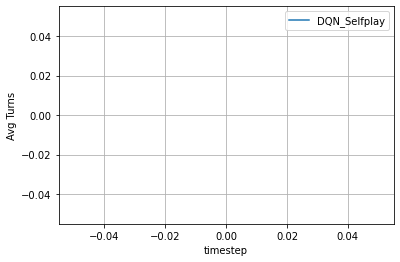

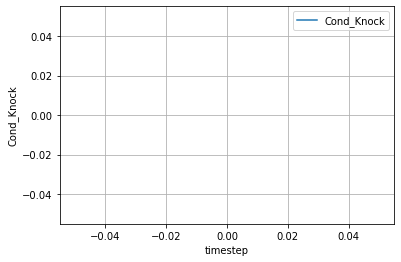

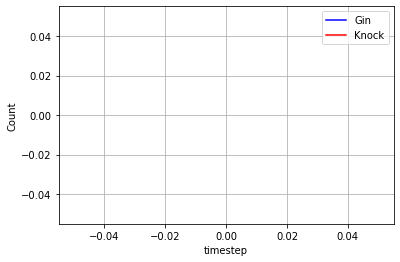

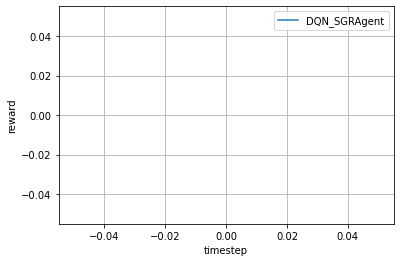

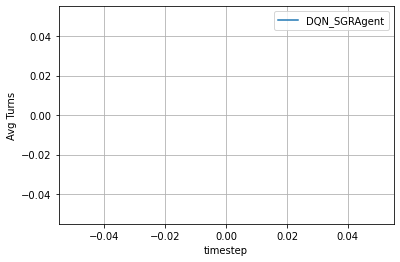

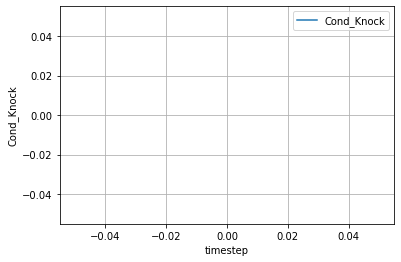

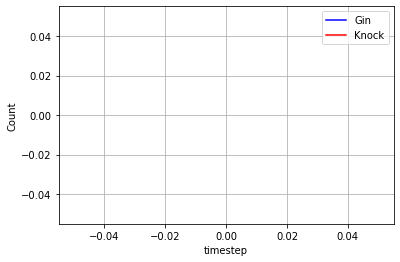

In [15]:
# Training Loop 2
for episode in range(episode_num//4, 2*episode_num//4):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

In [ ]:
# Training Loop 3
for episode in range(2*episode_num//4, 3*episode_num//4):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

Streaming output truncated to the last 5000 lines.

Random:

----------------------------------------
  timestep     |  5108363
  reward       |  -0.3964999999999999
  Avg Turns    |  42.77
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 14 | Other: 86
----------------------------------------

Selfplay:

----------------------------------------
  timestep     |  5108363
  reward       |  -0.32110000000000016
  Avg Turns    |  34.41
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 26 | Other: 74
----------------------------------------

SGRAgent:

----------------------------------------
  timestep     |  5108363
  reward       |  -0.4578000000000001
  Avg Turns    |  14.69
  Cond_Knock   |  1.0
  Gin: 0 | Knock: 6 | Other: 94
----------------------------------------
INFO - Agent dqn, step 2480880, rl-loss: 0.024992700666189194
----------------------------------------------------------------------

Random:

----------------------------------------
  timestep     |  5111741
  reward       |  -0.385699999

In [ ]:
# Training Loop 4
for episode in range(3*episode_num//4, episode_num):

    # Generate data from the environment
    trajectories, _ = env.run(is_training=True)

    # Feed transitions into agent memory, and train the agent
    for ts in trajectories[0]:
        agent.feed(ts)

    # Evaluate the performance.
    if episode % evaluate_every == 0:
        print('\n----------------------------------------------------------------------\n')
        print('Random:')
        rewards, actions_rand = tournament3(random_env, evaluate_num)
        reward_rand = rewards[0]
        logger_rand.log_performance2(env.timestep, reward_rand, actions_rand)
        print('\nSelfplay:')
        rewards, actions_self = tournament3(selfplay_env, evaluate_num)
        reward_self = rewards[0]
        logger_self.log_performance2(env.timestep, reward_self, actions_self)
        print('\nSGRAgent:')
        rewards, actions_sgr = tournament3(SGRAgent_env, evaluate_num)
        reward_sgr = rewards[0]
        logger_sgr.log_performance2(env.timestep, reward_sgr, actions_sgr)
        
        # save best reward model for each environment
        if reward_rand > max_reward_rand:
            max_reward_rand = reward_rand
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand.pth'))

        if reward_self > max_reward_self:
            max_reward_self = reward_self
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self.pth'))

        if reward_sgr > max_reward_sgr:
            max_reward_sgr = reward_sgr
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr.pth'))
        
        # save best knock model for each environment
        Cond_Knock = actions_rand['Knock'] / actions_rand['Knock_Possible'] if actions_rand['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_rand:
            max_knock_rand = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_rand_knock.pth'))

        Cond_Knock = actions_self['Knock'] / actions_self['Knock_Possible'] if actions_self['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_self:
            max_knock_self = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_self_knock.pth'))

        Cond_Knock = actions_sgr['Knock'] / actions_sgr['Knock_Possible'] if actions_sgr['Knock_Possible'] > 0  else 0
        if Cond_Knock > max_knock_sgr:
            max_knock_sgr = Cond_Knock
            state_dict = agent.get_state_dict() 
            torch.save(state_dict, os.path.join(save_dir, 'model_sgr_knock.pth'))

# Close files in the logger
logger_rand.close_files()
logger_self.close_files()
logger_sgr.close_files()

# Plot the learning curve
logger_rand.plot2('DQN_Random')
logger_self.plot2('DQN_Selfplay')
logger_sgr.plot2('DQN_SGRAgent')

# Save model
state_dict = agent.get_state_dict() 
torch.save(state_dict, os.path.join(save_dir, 'model_posttrain.pth'))

clear_output()

#### Training Plots

In [ ]:
model_name = 'models/dqn/{}/{}/model_posttrain.pth'.format(dir, dqn_model_name)

In [ ]:
checkpoint = torch.load(model_name, map_location=device)

In [ ]:
agent.load(checkpoint)

###### Random

In [ ]:
_, actions = tournament3(random_env, evaluate_num)
clear_output()
print(actions)

In [ ]:
Image(log_dir + '/rand_fig.png')

In [ ]:
Image(log_dir + '/rand_fig2.png')

In [ ]:
Image(log_dir + '/rand_fig3.png')

In [ ]:
Image(log_dir + '/rand_fig4.png')

###### Selfplay

In [ ]:
_, actions = tournament3(selfplay_env, evaluate_num)
clear_output()
print(actions)

In [ ]:
Image(log_dir + '/self_fig.png')

In [ ]:
Image(log_dir + '/self_fig2.png')

In [ ]:
Image(log_dir + '/self_fig3.png')

In [ ]:
Image(log_dir + '/self_fig4.png')

###### SGRAgent

In [ ]:
_, actions = tournament3(SGRAgent_env, evaluate_num)
clear_output()
print(actions)

In [ ]:
Image(log_dir + '/sgr_fig.png')

In [ ]:
Image(log_dir + '/sgr_fig2.png')

In [ ]:
Image(log_dir + '/sgr_fig3.png')

In [ ]:
Image(log_dir + '/sgr_fig4.png')